### Import sdk

In [1]:
import os
os.chdir("/home/ma-user/work/rop")
from naie.context import Context as context
from naie.datasets import data_reference
from naie.feature_processing import data_flow
from naie.feature_analysis import data_analysis
from naie.feature_processing.expression import col, cols, cond, f_and, f_not, f_or
from naie.common.data.typedefinition import StepType, ColumnRelationship, JoinType, ColumnSelector,DynamicColumnsSelectorDetails, StaticColumnsSelectorDetails, ColumnsSelectorDetails, DataProcessMode

INFO:root:Using MoXing-v1.17.3-e29493b7
INFO:root:Using OBS-Python-SDK-3.20.9.1
INFO:root:Successfully apply patch MoXingPatchRemoveAKSK.py


In [2]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# 使用r2_score评价模型在测试集和训练集上的性能，并输出评估结果
from sklearn.metrics import r2_score  #评价回归预测模型的性能
from sklearn.metrics import mean_squared_error#MSE
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import roc_curve, auc

In [3]:
# if you want to use hyper param, edit '__debug.json' in 'naie_platform' folder

## 选择数据

In [4]:
#@param_dict {"id":"data-reference"}
data_reference_kwargs = {
    "dataset": "quancan",
    "dataset_entity": "train_merge_rop",
    "file_list": None,
    "file_type": "csv",
    "encoding": "utf-8",
    "attrs": {
        "is_time_series": False,
        "time_column": None,
        "time_format": None,
        "id_column": None,
        "do_analysis": False
    },
    "enable_local_cache": False
}
datareference = data_reference.get_data_reference(**data_reference_kwargs) #@return {"id":"default.datareference"}
dataflow = data_flow.create_data_flow(data_reference=datareference) #@return {"id":"default.dataflow"}
dataflow.show_head()

resolve path s3://bucket-y4jowg9t/55f503dc56004fcdb5f2c9ddb73a34dd/eff1ec6300ec46b793e3f649da0d5fd9/Dataset quancan train_merge_rop.


<naie.common.display.NAIEDisplay> (naie.spread)

## 自定义操作

In [5]:
train_rop = dataflow.to_DataFrame()
# train_merge.loc[train_merge.ROP>20,'ROP']=None
train_rop.interpolate()
# train_merge=train_merge.drop(['Dcs','MW_out','conductivity_out','temprature_out','formation pressure gradient','FV'],axis=1)
train_rop=train_rop.fillna(method='ffill')

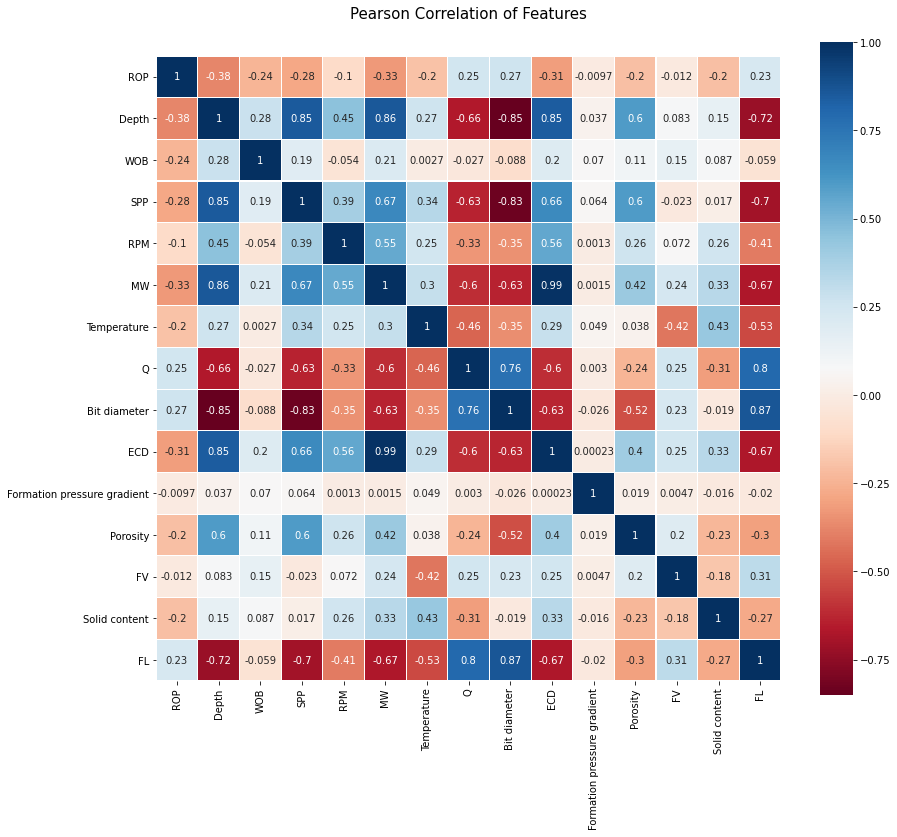

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_rop.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [7]:
train_rop=train_rop.drop(['Formation pressure gradient','FV'],axis=1)

In [8]:
train_rop.describe()

,ROP,Depth,WOB,SPP,RPM,MW,Temperature,Q,Bit diameter,ECD,Porosity,Solid content,FL
count,2383.000000,2383.000000,2383.00000,2383.000000,2383.000000,2383.000000,2383.00000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000,2383.000000
mean,2.868321,1200.530843,57.79572,5.293957,51.379354,1.145069,30.00042,1.981565,314.272514,1.158682,1.527000,0.245741,4.112065
std,2.617734,687.413172,32.62180,2.187228,25.028657,0.066219,2.92855,0.293285,69.423353,0.065808,0.532521,0.059597,0.982396
min,0.260000,10.000000,0.00000,0.000000,30.000000,1.020000,20.00000,0.647000,216.000000,1.000000,1.000000,0.100000,3.300000
25%,1.320000,605.500000,32.80000,4.200000,33.000000,1.100000,28.00000,1.823000,311.100000,1.110000,1.250000,0.200000,3.528571
50%,2.070000,1201.000000,48.20000,5.400000,35.000000,1.140000,30.00000,1.878000,311.100000,1.150000,1.310000,0.200000,3.700000
75%,3.490000,1796.500000,74.50000,6.300000,60.000000,1.180000,32.00000,1.943000,311.100000,1.200000,1.690000,0.300000,3.969031
max,28.300000,2389.000000,202.30000,11.500000,120.000000,1.300000,36.00000,2.807000,444.500000,1.310000,12.830000,0.400000,7.000000


In [9]:
# train_merge.to_csv('train_merge1.csv')
from naie.context import Context
import moxing as mox
# mox.file.copy('train_merge1.csv', os.path.join(Context.get_output_path(), 'train_merge1.csv'))

In [10]:
train_2=train_rop.copy(deep=True) 
numerical_features=train_rop.columns
from scipy.signal import savgol_filter

filter_features=['ROP', 'Depth', 'WOB', 'SPP',  'MW', 'Temperature', 'Q',
        'ECD', 'Porosity' ]
for i in filter_features:
    train_2[i]=savgol_filter(train_2[i],11,3)
cols=train_2.columns
train_2_stand=train_2
# # cols=['ROP','Depth', 'WOB', 'RPM', 'Pump_rate']
# cols=['ROP', 'Depth', 'WOB', 'RPM', 'TOB', 'Pump_pressure', 'Pump_rate']
min_max_scaler = MinMaxScaler()
# min_max_scaler=StandardScaler()
train_2_stand = min_max_scaler.fit_transform(train_2_stand)
train_2_stand=pd.DataFrame(columns=cols,data=train_2_stand)
# train_3_stand_hot=pd.concat([train_3_stand,X_train_cat],axis=1)

y = train_2_stand['ROP']   
# X = train.drop(["Rock_type",'Depth'], axis=1)
X = train_2_stand.drop(["ROP"], axis=1)

#将数据分割训练数据与测试数据
   
# cols=X.columns
# # min_max_scaler = MinMaxScaler()
# min_max_scaler=StandardScaler()
# X = min_max_scaler.fit_transform(X)
# X=pd.DataFrame(columns=cols,data=X)

from sklearn.model_selection import train_test_split
# 随机采样20%的数据构建测试样本，其余作为训练样本

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
# X_train=X.head(2100)
# X_test=X.tail(283)
# y_train=y.head(2100)
# y_test=y.tail(283)

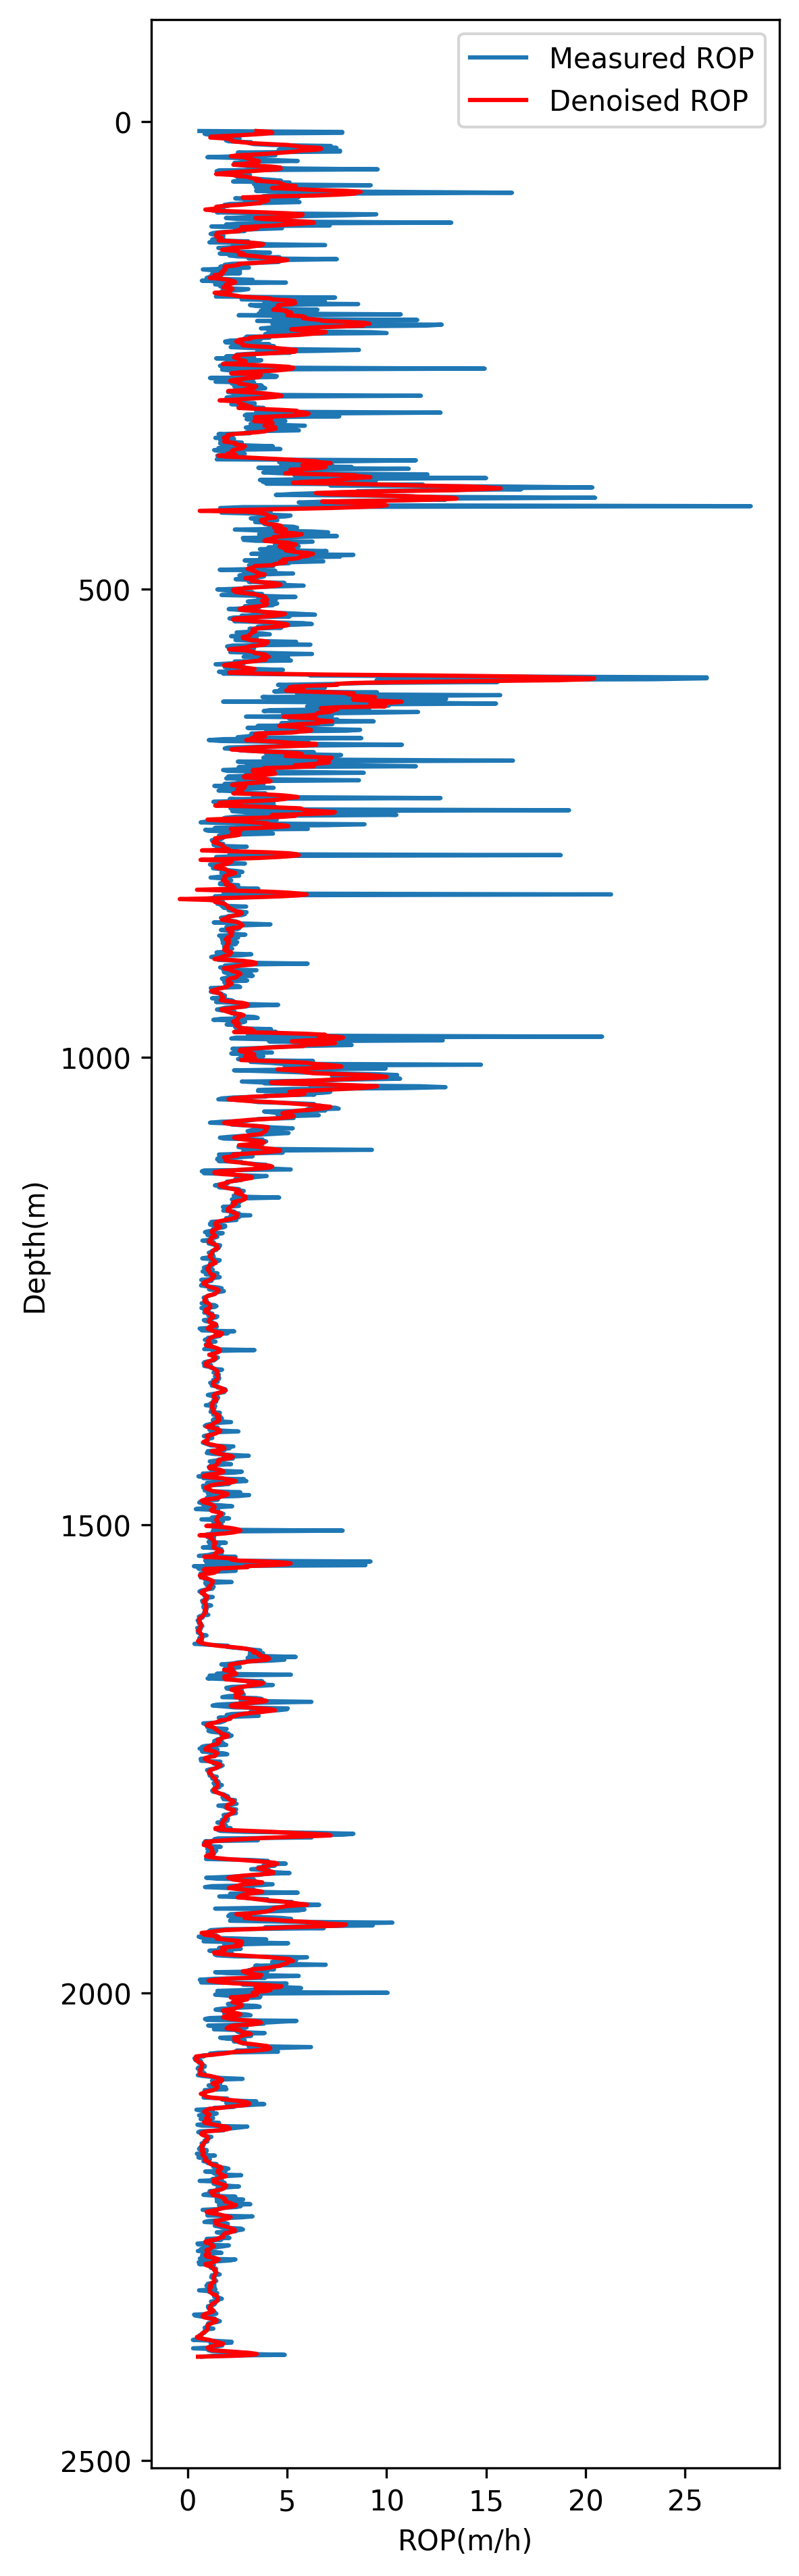

In [11]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['ROP'],train_rop['Depth'],label='Measured ROP')
plt.plot(train_2['ROP'],train_2['Depth'],color='r',label='Denoised ROP')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('ROP(m/h)')
plt.ylabel('Depth(m)')
plt.legend()
# plt.figure(figsize=(10,10),dpi=800)

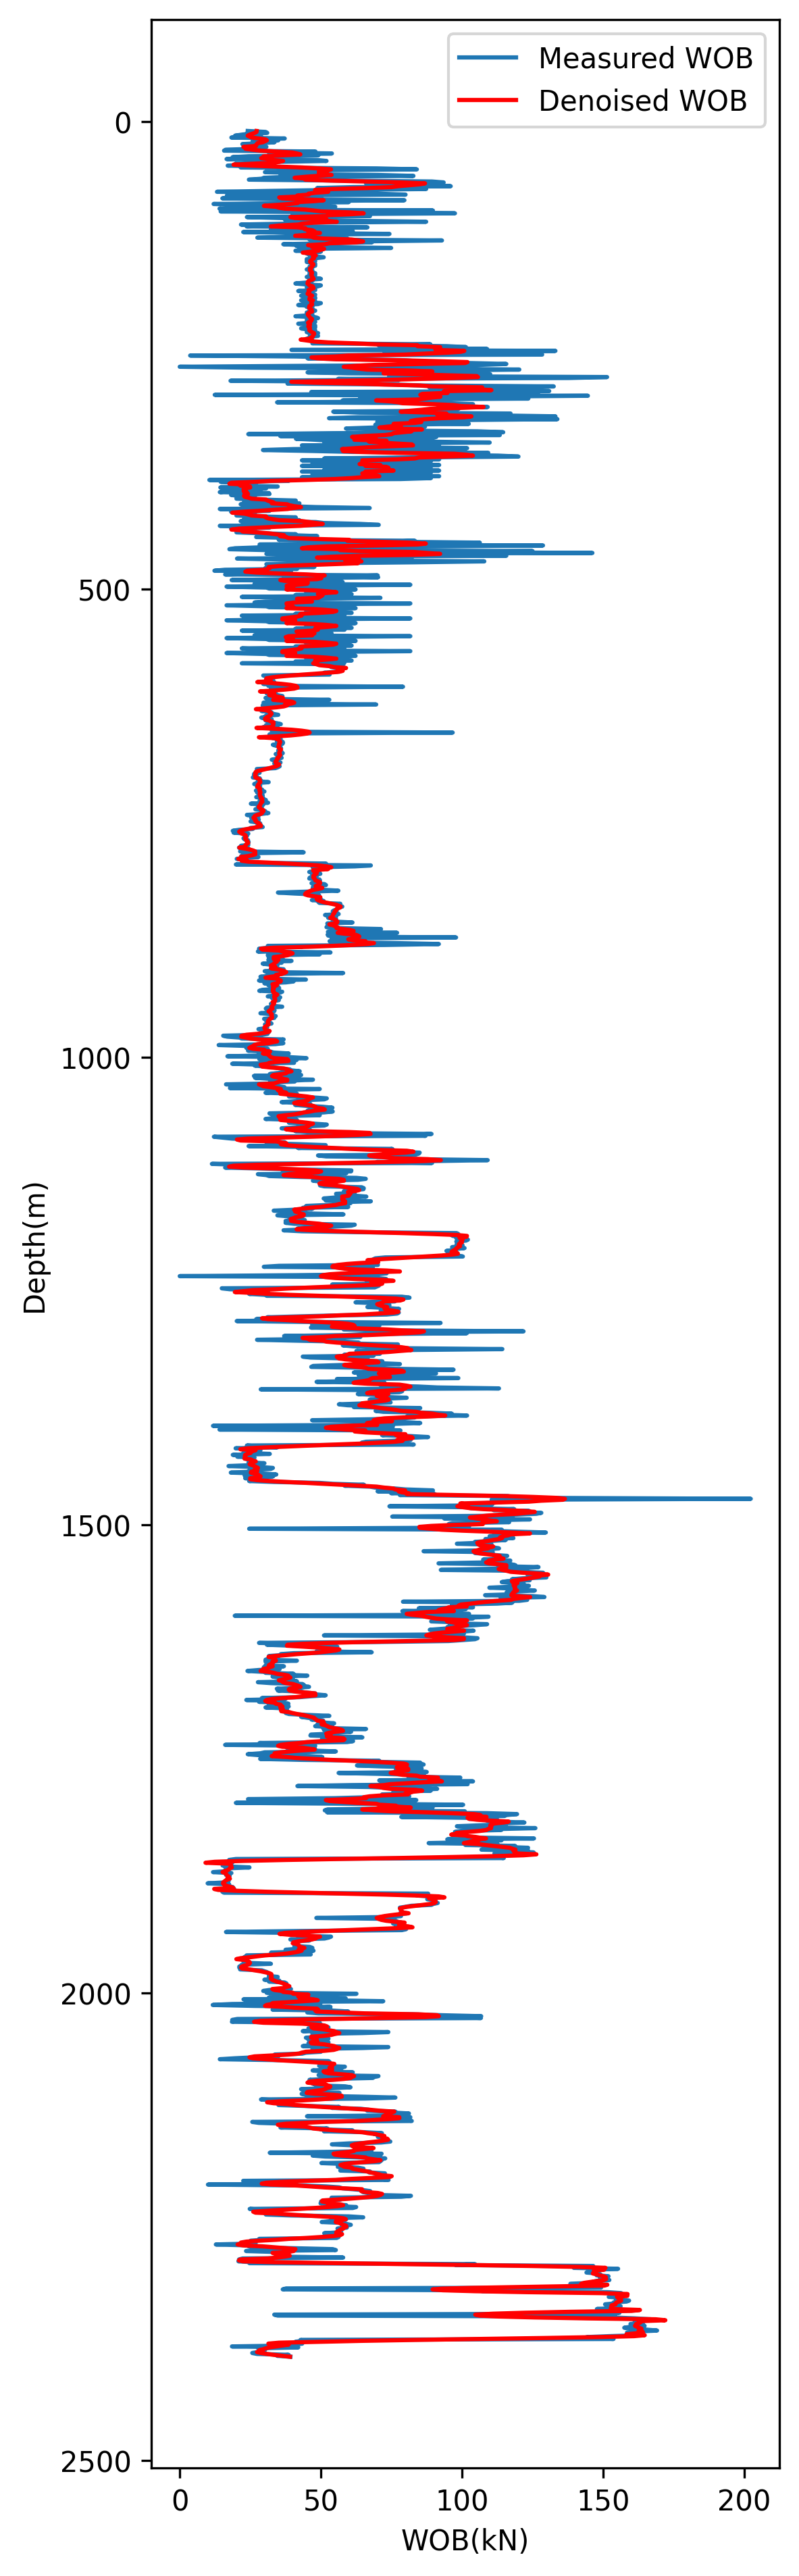

In [12]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['WOB'],train_rop['Depth'],label='Measured WOB')
plt.plot(train_2['WOB'],train_2['Depth'],color='r',label='Denoised WOB')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('WOB(kN)')
plt.ylabel('Depth(m)')
plt.legend()

In [13]:
['ROP', 'Depth', 'WOB', 'SPP',  'MW', 'Temperature', 'Q',
        'ECD', 'Porosity' ]

['ROP', 'Depth', 'WOB', 'SPP', 'MW', 'Temperature', 'Q', 'ECD', 'Porosity']

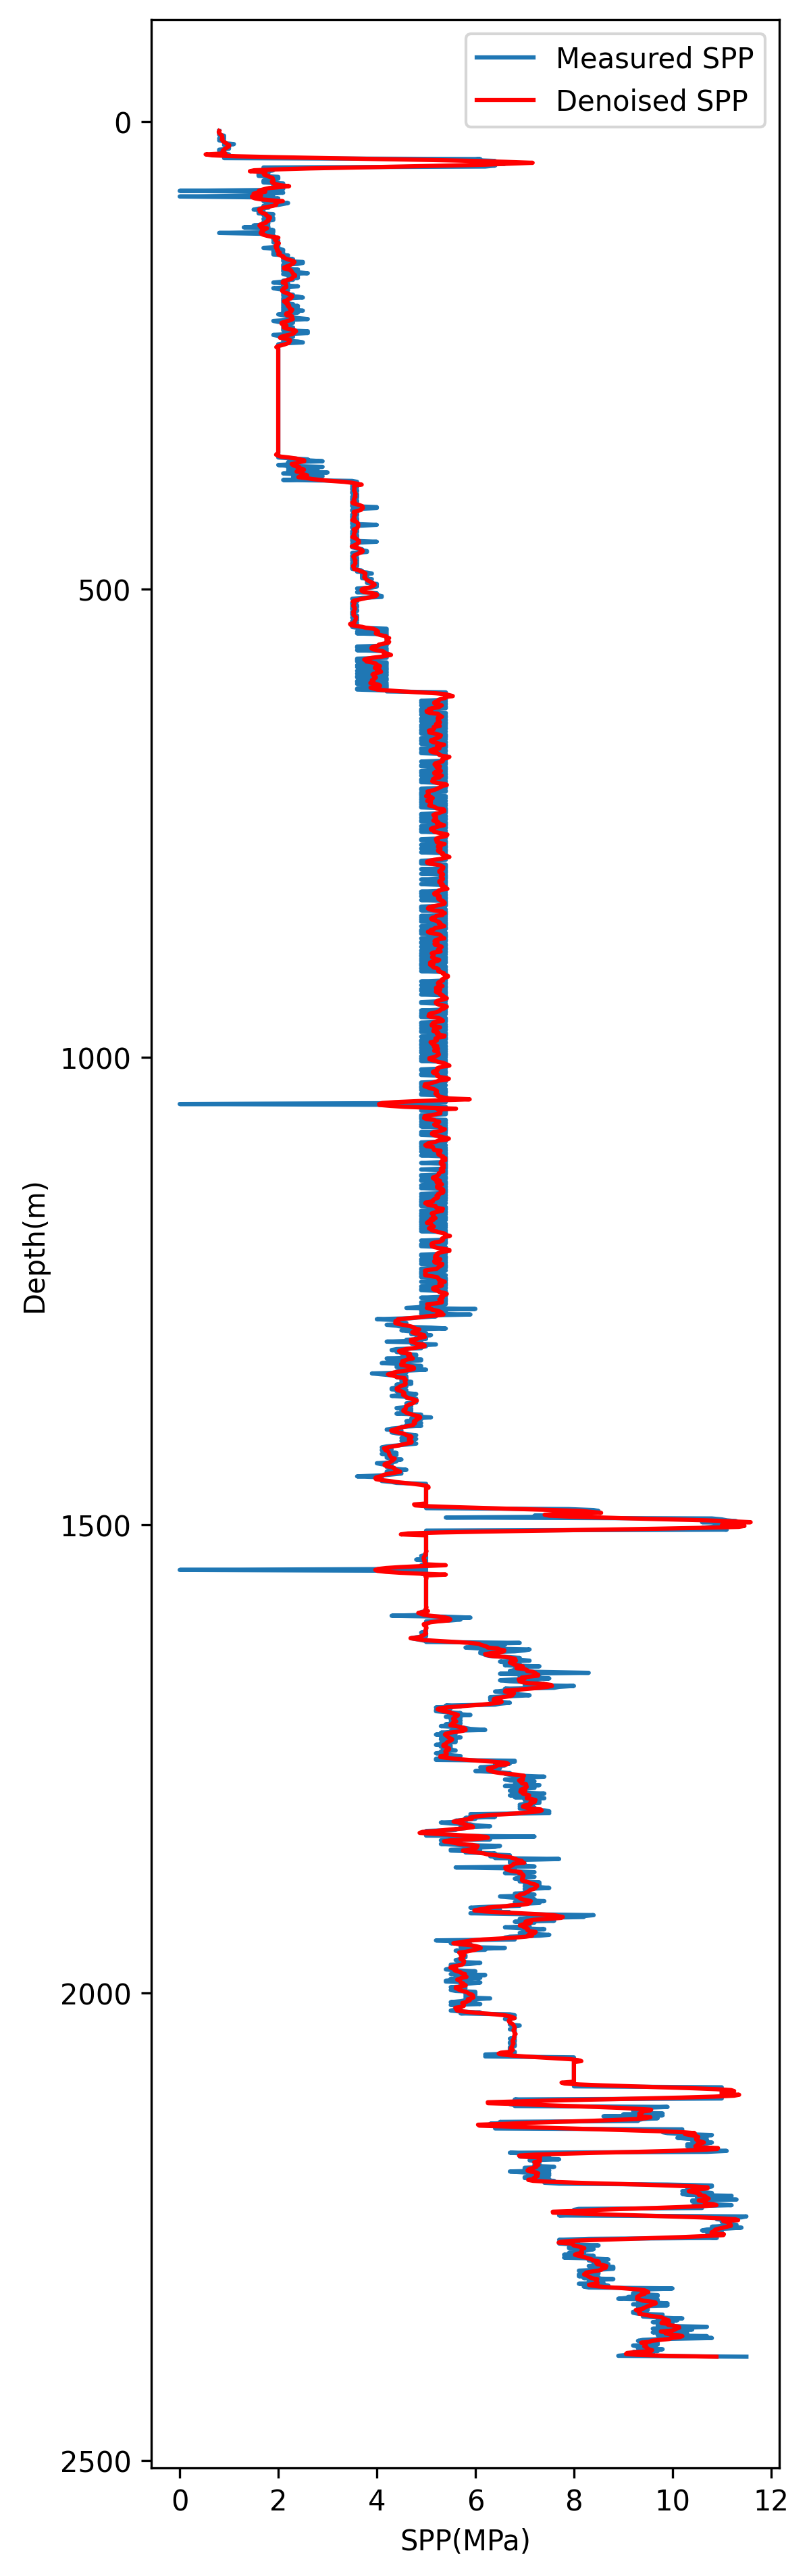

In [14]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['SPP'],train_rop['Depth'],label='Measured SPP')
plt.plot(train_2['SPP'],train_2['Depth'],color='r',label='Denoised SPP')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('SPP(MPa)')
plt.ylabel('Depth(m)')
plt.legend()

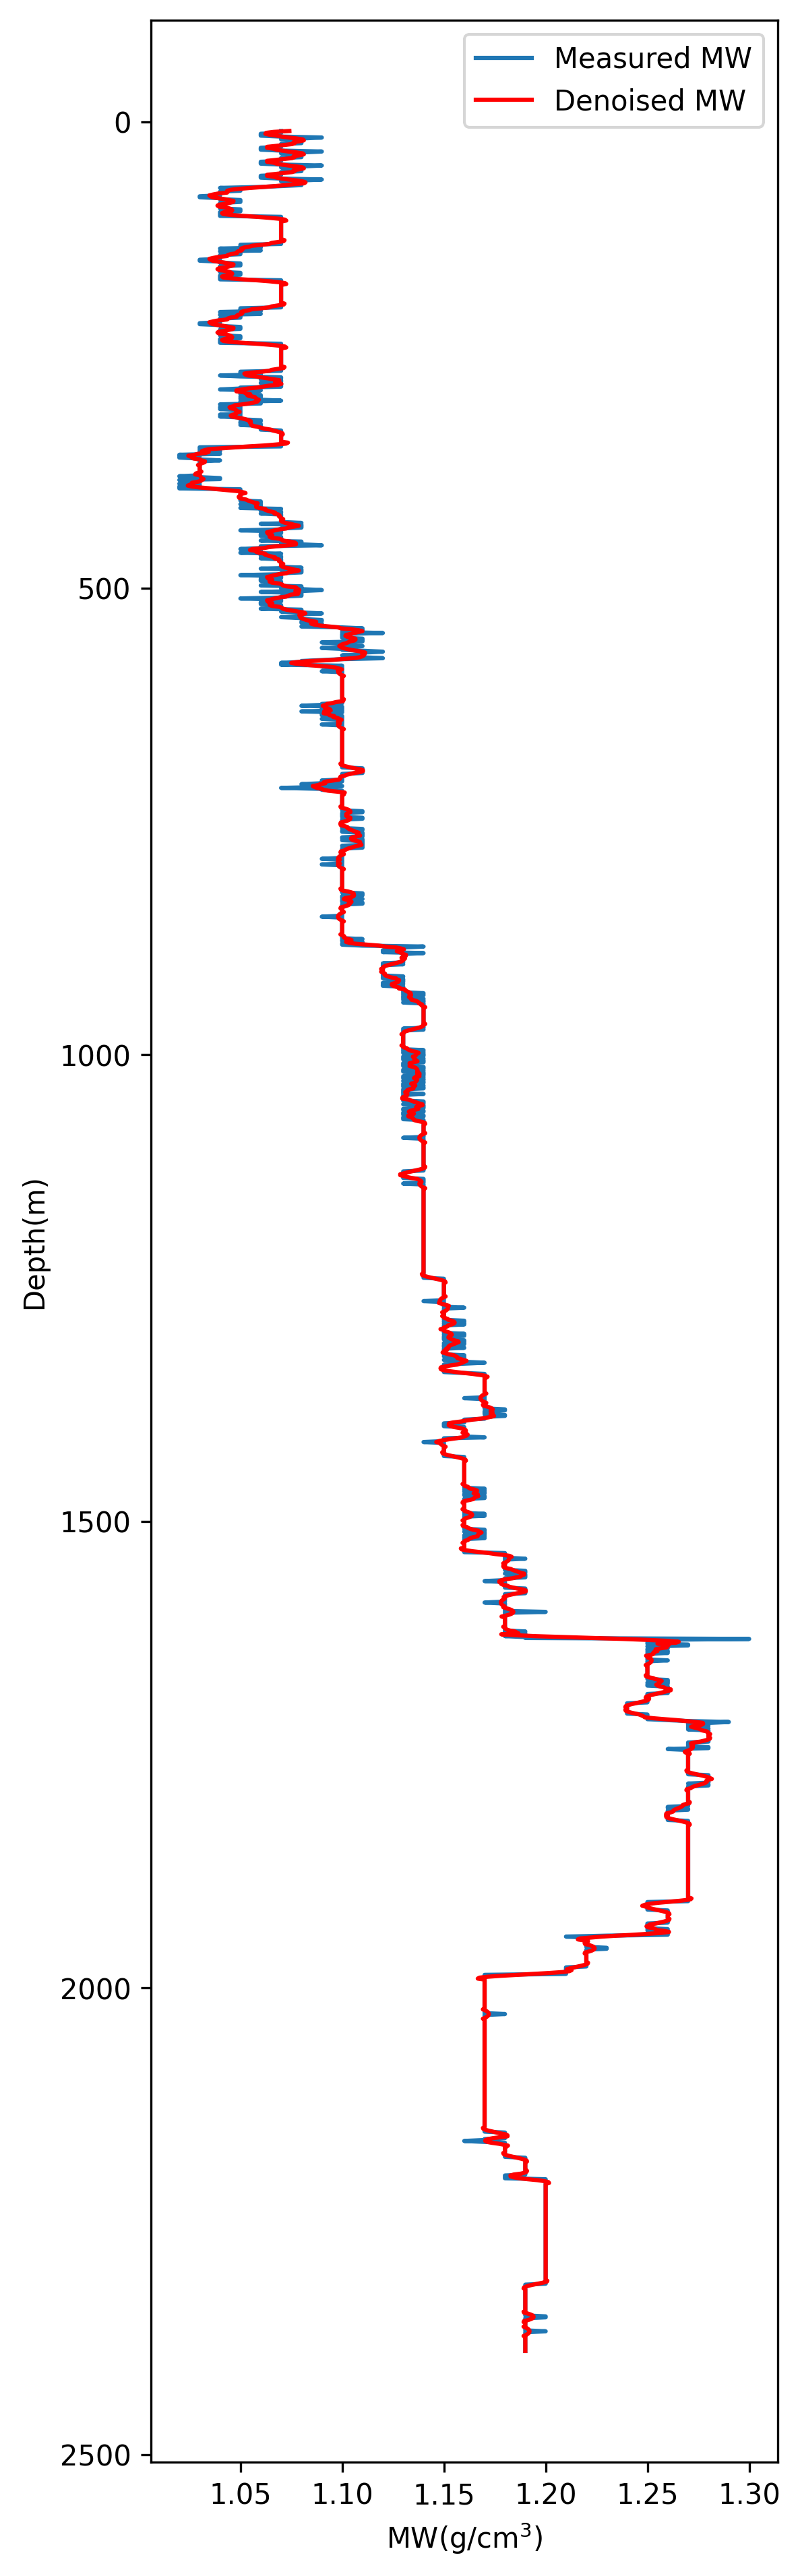

In [15]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['MW'],train_rop['Depth'],label='Measured MW')
plt.plot(train_2['MW'],train_2['Depth'],color='r',label='Denoised MW')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('MW(g/cm$^3$)')
plt.ylabel('Depth(m)')
plt.legend()

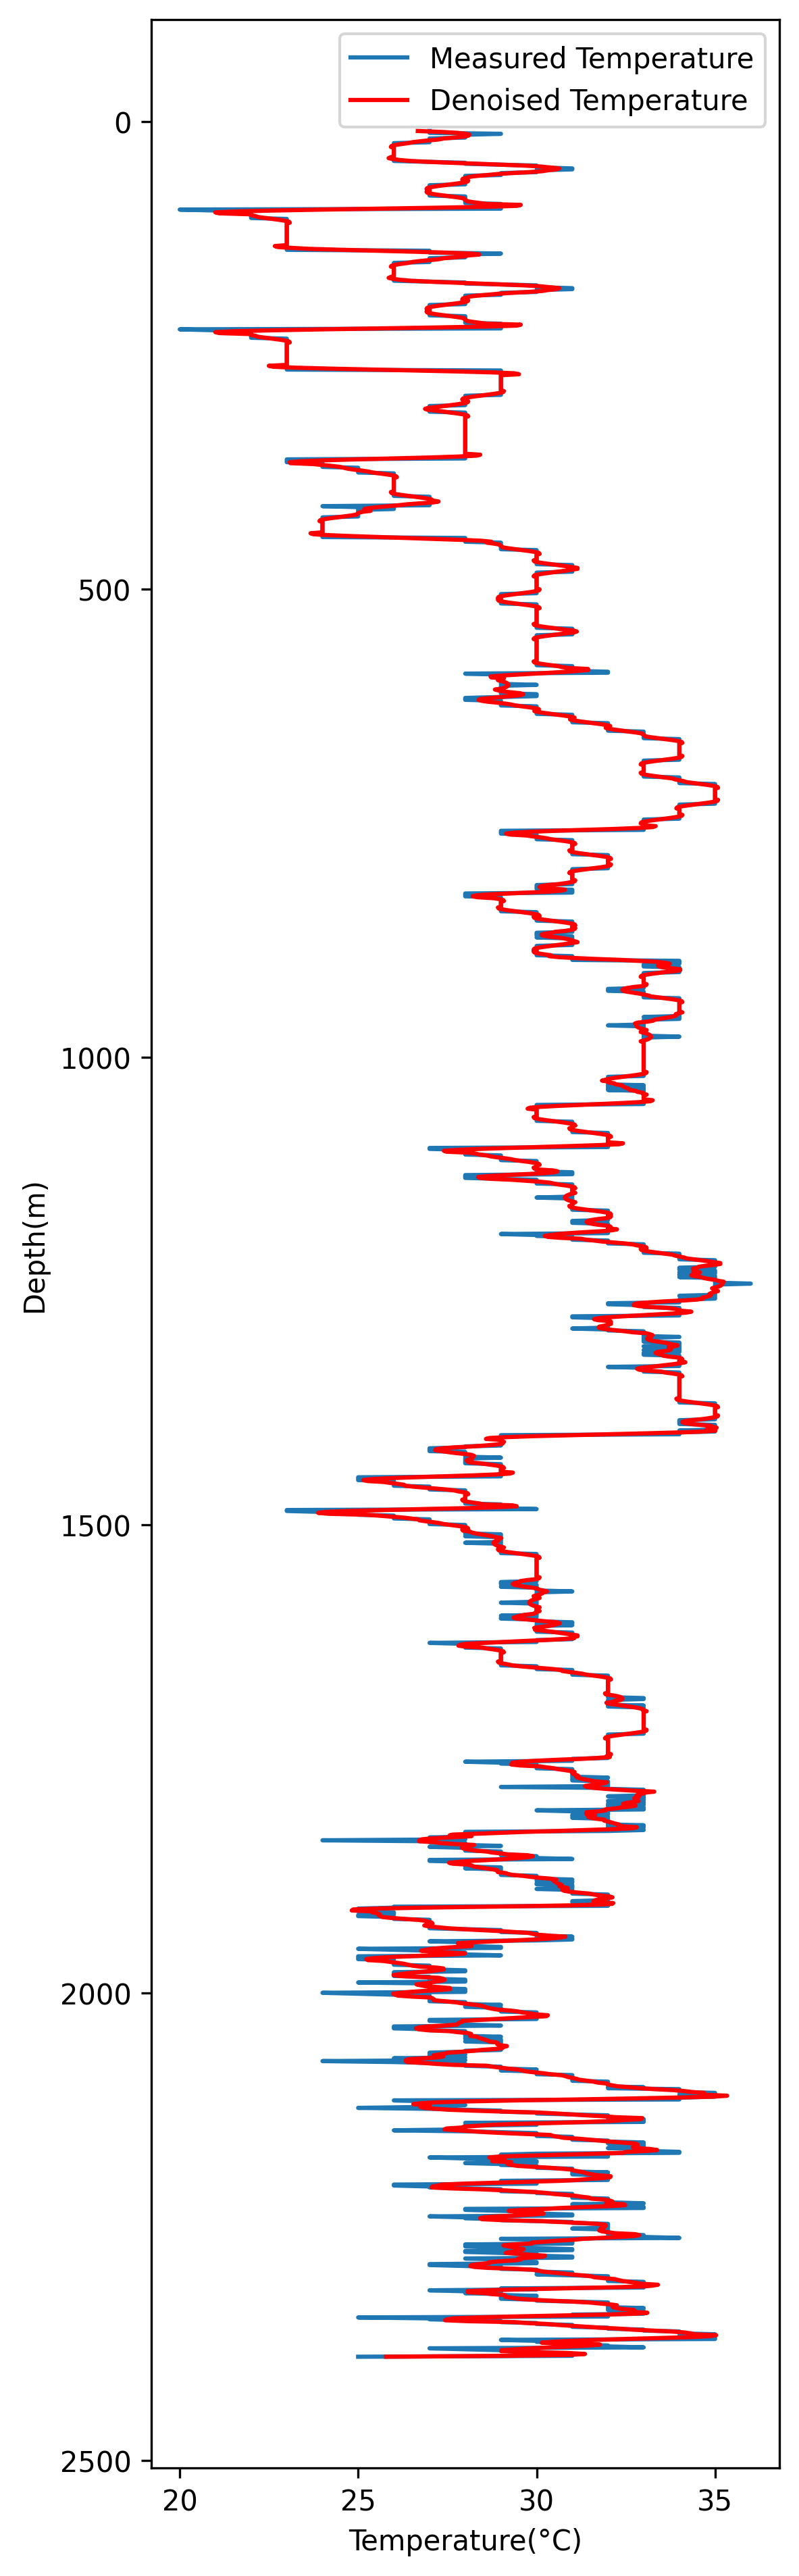

In [16]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Temperature'],train_rop['Depth'],label='Measured Temperature')
plt.plot(train_2['Temperature'],train_2['Depth'],color='r',label='Denoised Temperature')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Temperature(°C)')
plt.ylabel('Depth(m)')
plt.legend()

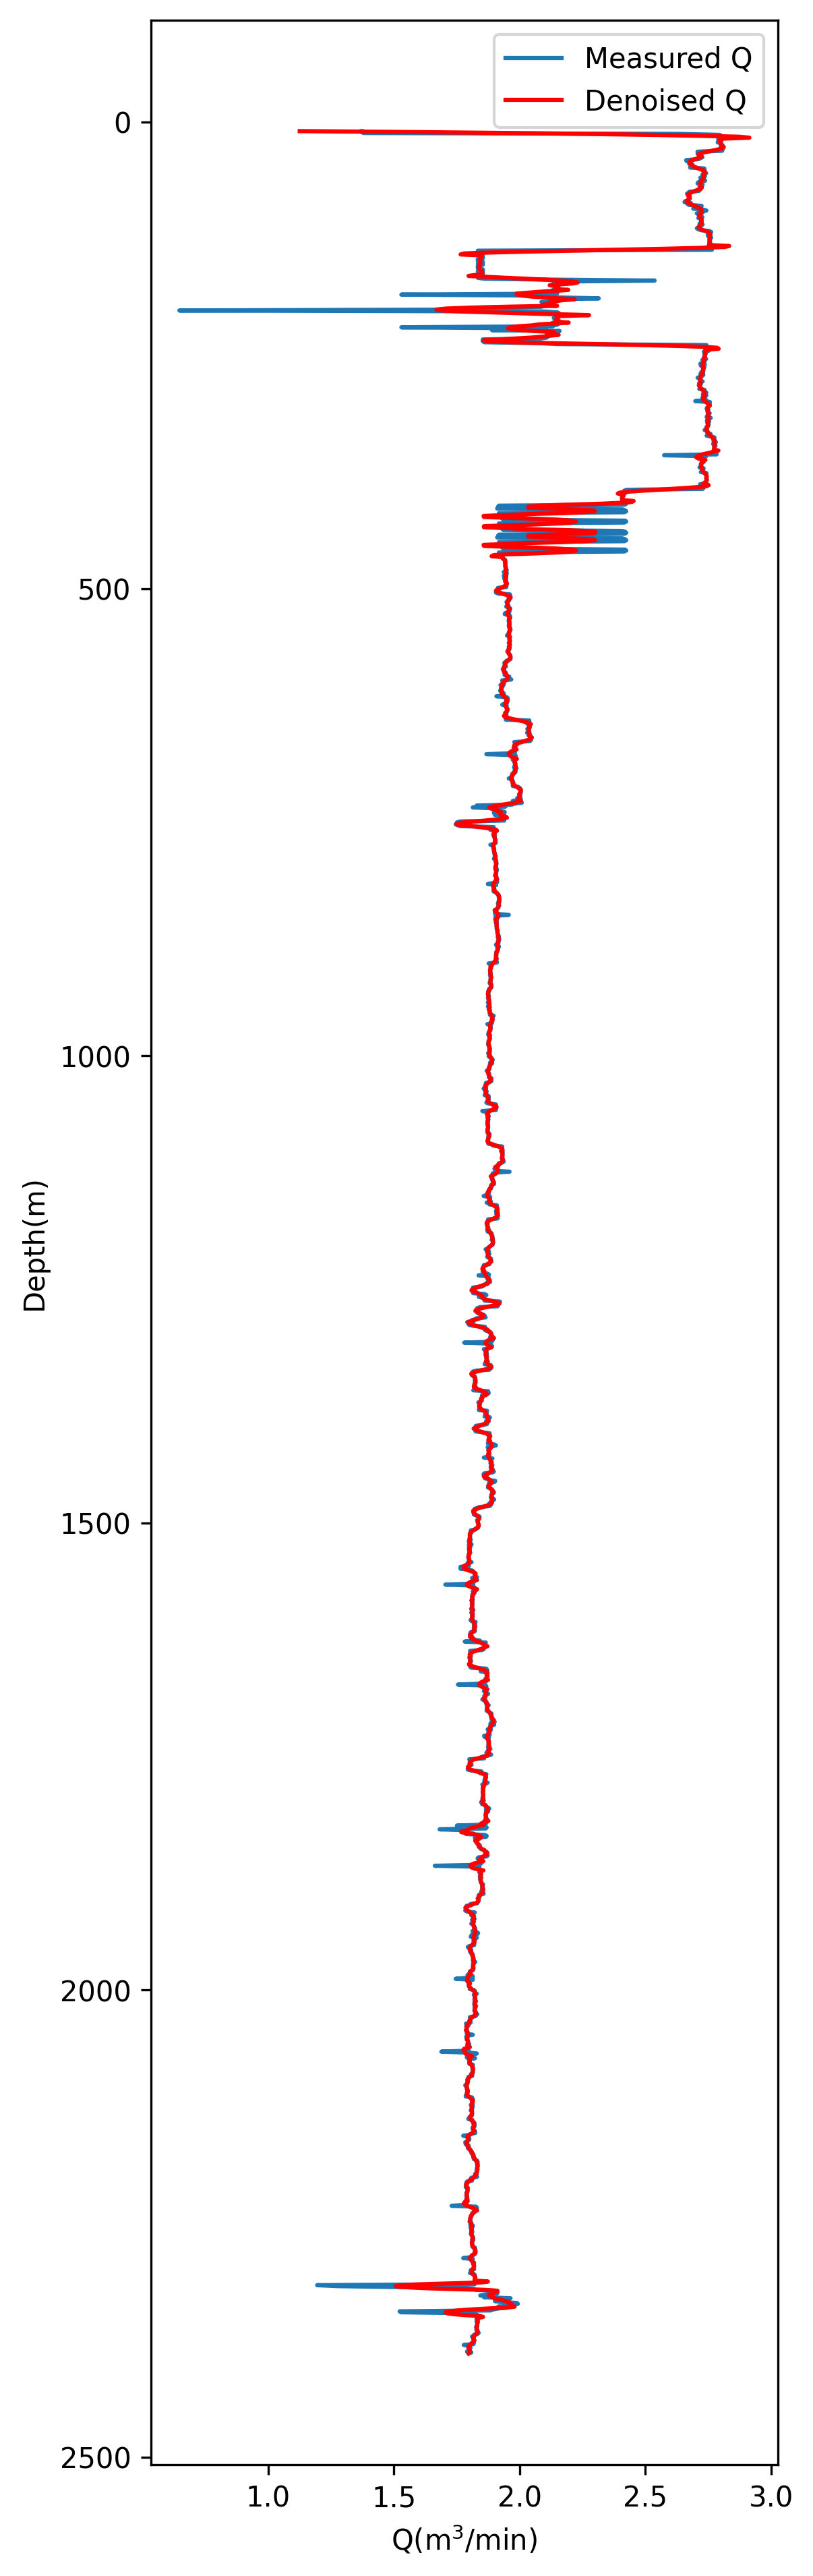

In [17]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Q'],train_rop['Depth'],label='Measured Q')
plt.plot(train_2['Q'],train_2['Depth'],color='r',label='Denoised Q')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Q(m$^3$/min)')
plt.ylabel('Depth(m)')
plt.legend()

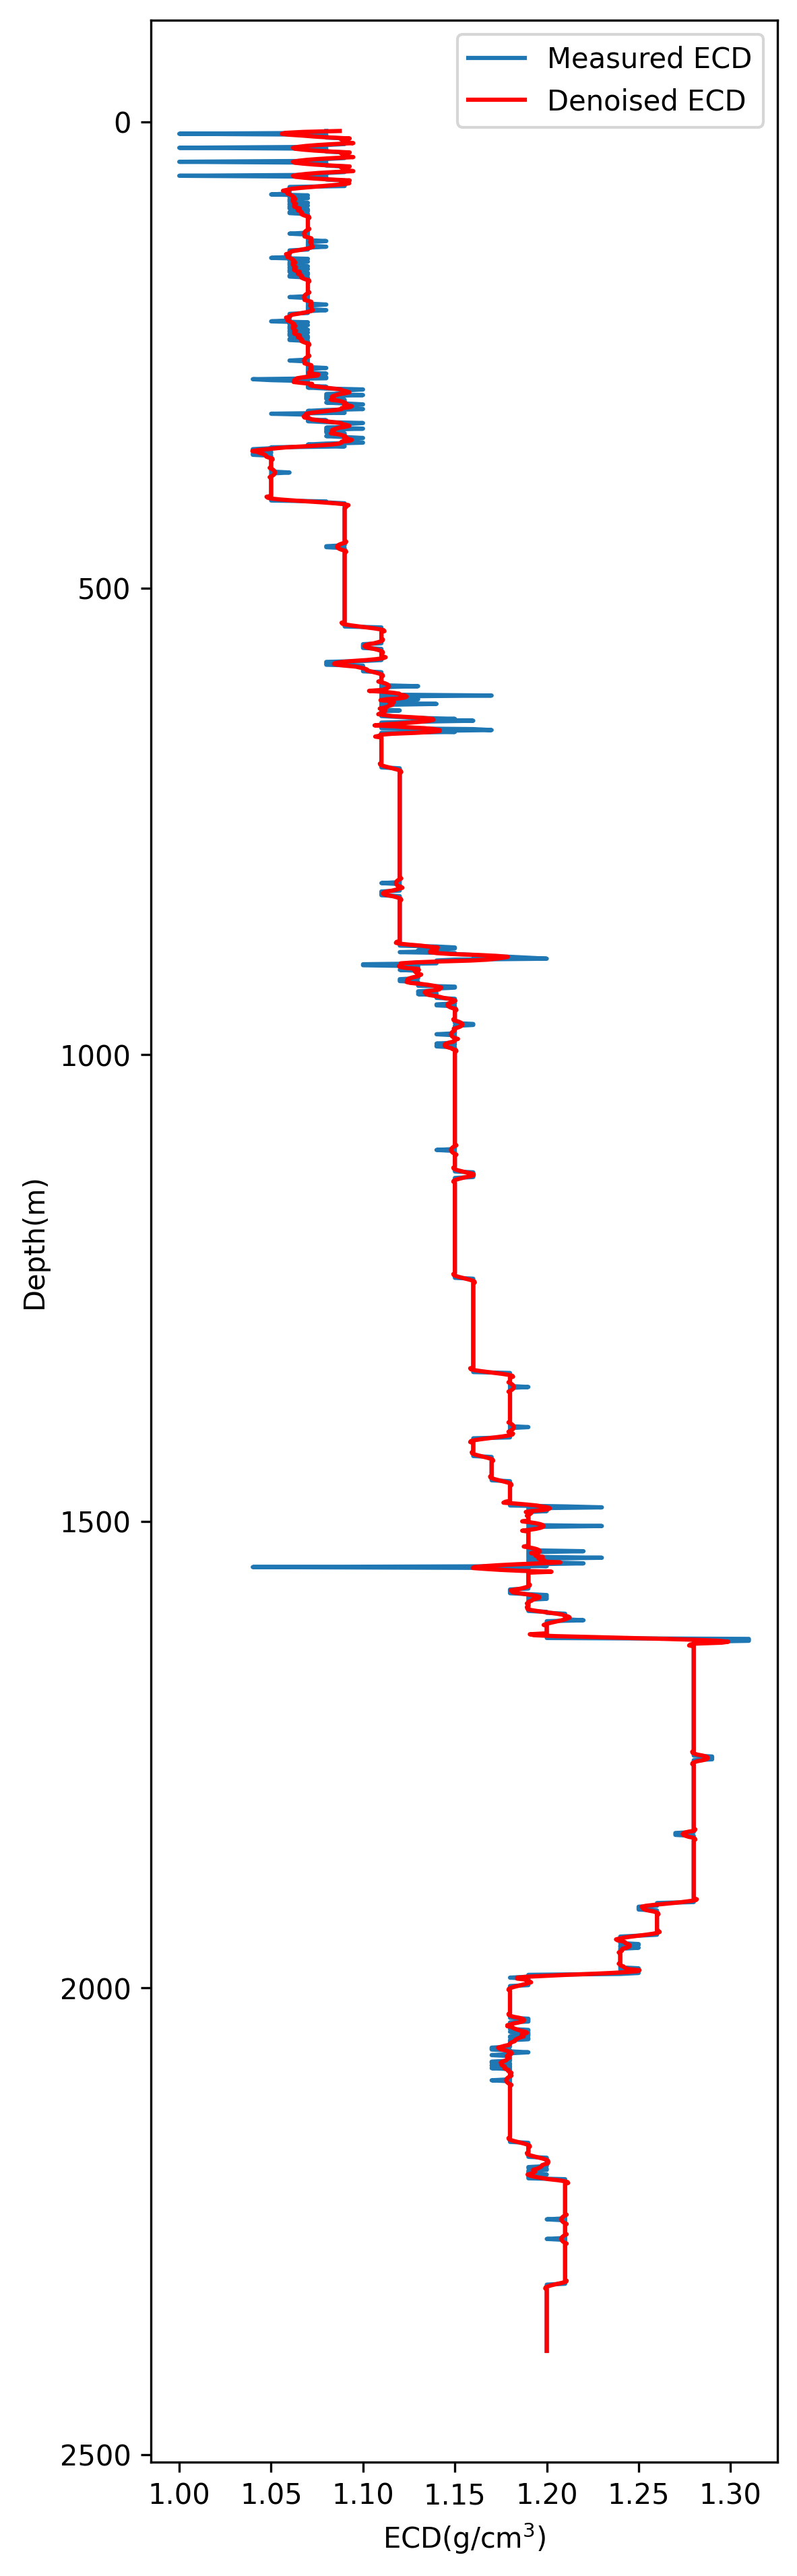

In [18]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['ECD'],train_rop['Depth'],label='Measured ECD')
plt.plot(train_2['ECD'],train_2['Depth'],color='r',label='Denoised ECD')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('ECD(g/cm$^3$)')
plt.ylabel('Depth(m)')
plt.legend()

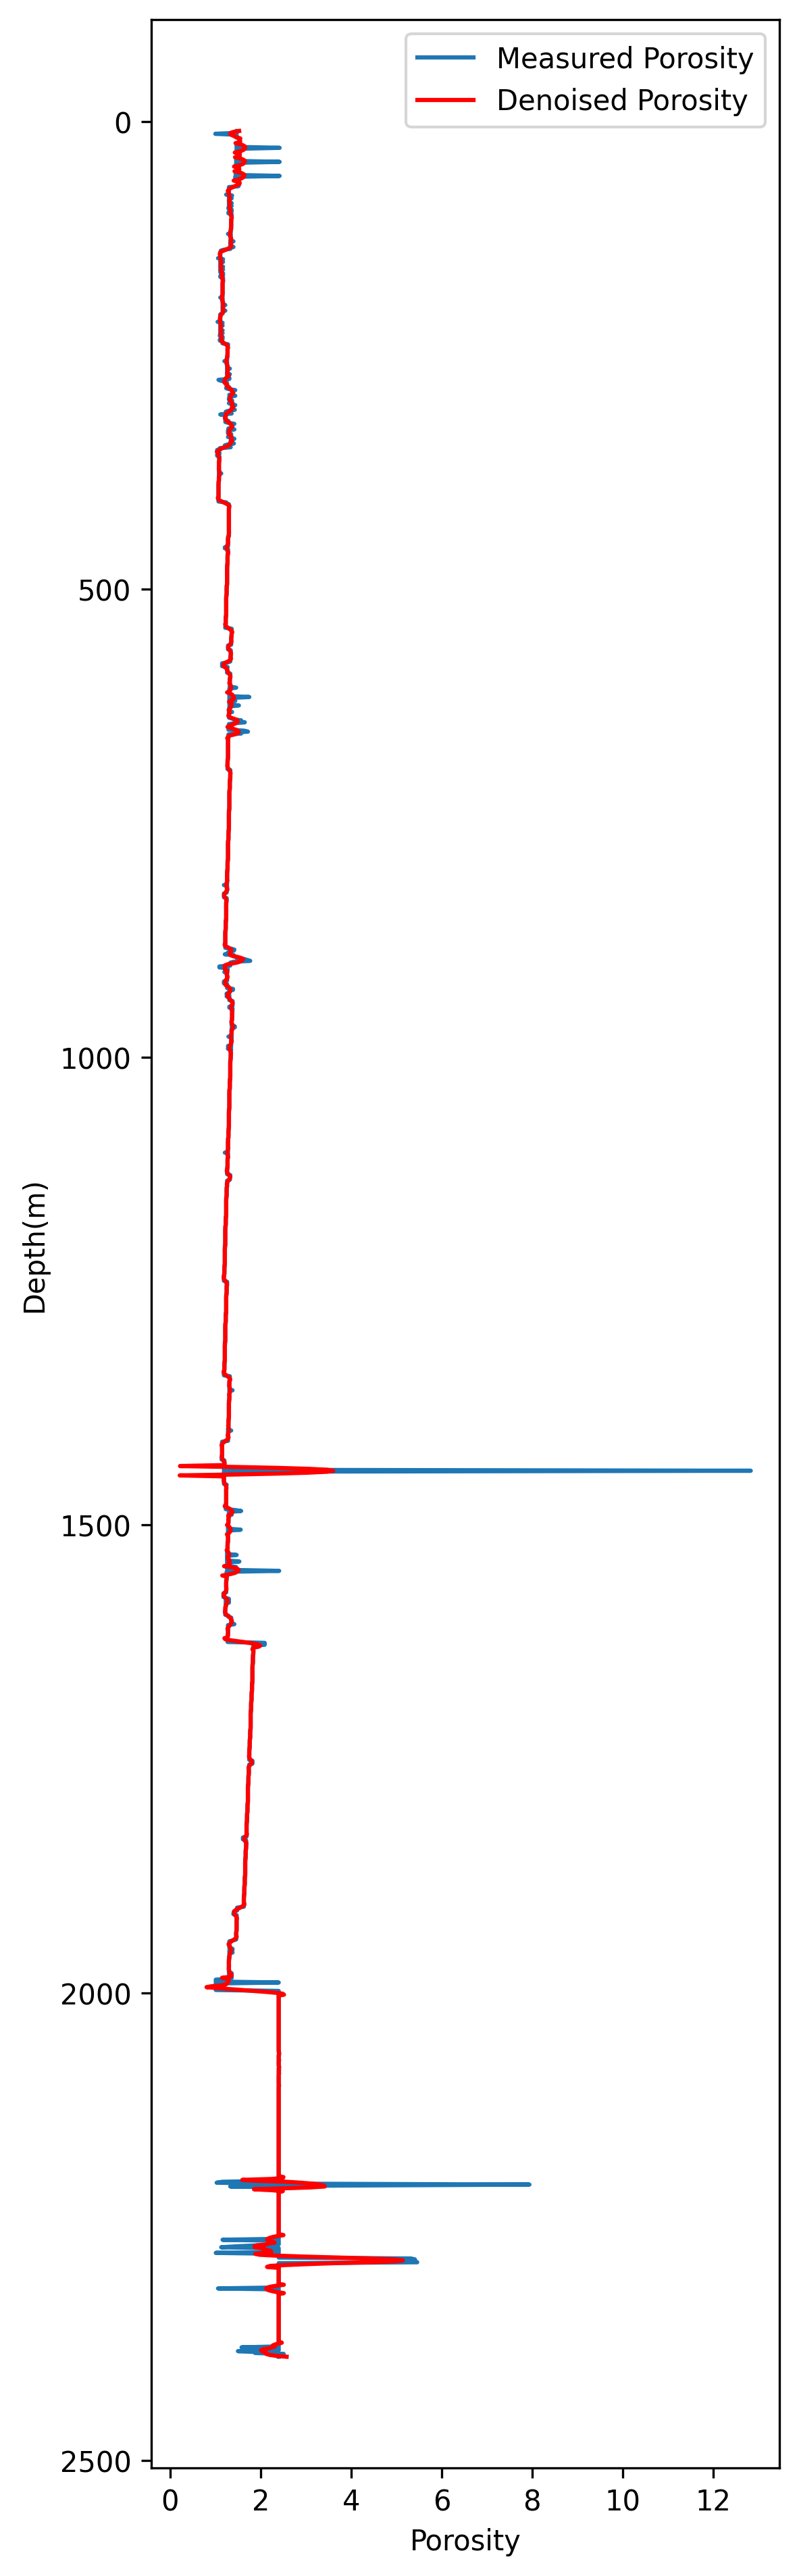

In [19]:
fig1=plt.figure(figsize=(4,16),dpi=300)
plt.plot(train_rop['Porosity'],train_rop['Depth'],label='Measured Porosity')
plt.plot(train_2['Porosity'],train_2['Depth'],color='r',label='Denoised Porosity')
ax = plt.gca()  
ax.invert_yaxis()
plt.xlabel('Porosity')
plt.ylabel('Depth(m)')
plt.legend()

In [20]:
# from sklearn.linear_model import  RidgeCV
from sklearn.metrics import mean_squared_error#MSE
from sklearn.ensemble import ExtraTreesRegressor
# for i in [10,100,200,300]:
ET =   ExtraTreesRegressor(n_estimators=300,random_state=42,max_depth=18,min_samples_split=2)
#模型训练
ET.fit(X_train, y_train)    
#预测
y_test_pred_ET = ET.predict(X_test)
y_train_pred_ET = ET.predict(X_train)
# 评估，使用r2_score评价模型在测试集和训练集上的性能
#     print('i',i)
print ('The r2 score of ET on test is', r2_score(y_test, y_test_pred_ET))
print ('The r2 score of ET on train is', r2_score(y_train, y_train_pred_ET))
print('The RMSE of ET on train is',mean_squared_error(y_train, y_train_pred_ET)**0.5)#RMSE
print('The RMSE of ET on test is',mean_squared_error(y_test, y_test_pred_ET)**0.5)#RMSE
#     print('############')

The r2 score of ET on test is 0.9286316143251927
The r2 score of ET on train is 0.999731657575786
The RMSE of ET on train is 0.0016348479020123284
The RMSE of ET on test is 0.029960901900498695


In [21]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
y_test_max=y_test_i.max()
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_train_pred_ET_i=y_minmax.inverse_transform(y_train_pred_ET.reshape(-1,1))

In [22]:
y_train_pred_ET_i=y_minmax.inverse_transform(y_train_pred_ET.reshape(-1,1))
y_test_pred_ET_i=y_minmax.inverse_transform(y_test_pred_ET.reshape(-1,1))
print('The RMSE of ET on train is',mean_squared_error(y_train_i, y_train_pred_ET_i)**0.5)
print('The RMSE of ET on test is',mean_squared_error(y_test_i, y_test_pred_ET_i)**0.5)

The RMSE of ET on train is 0.03405060448144445
The RMSE of ET on test is 0.6240255251057267


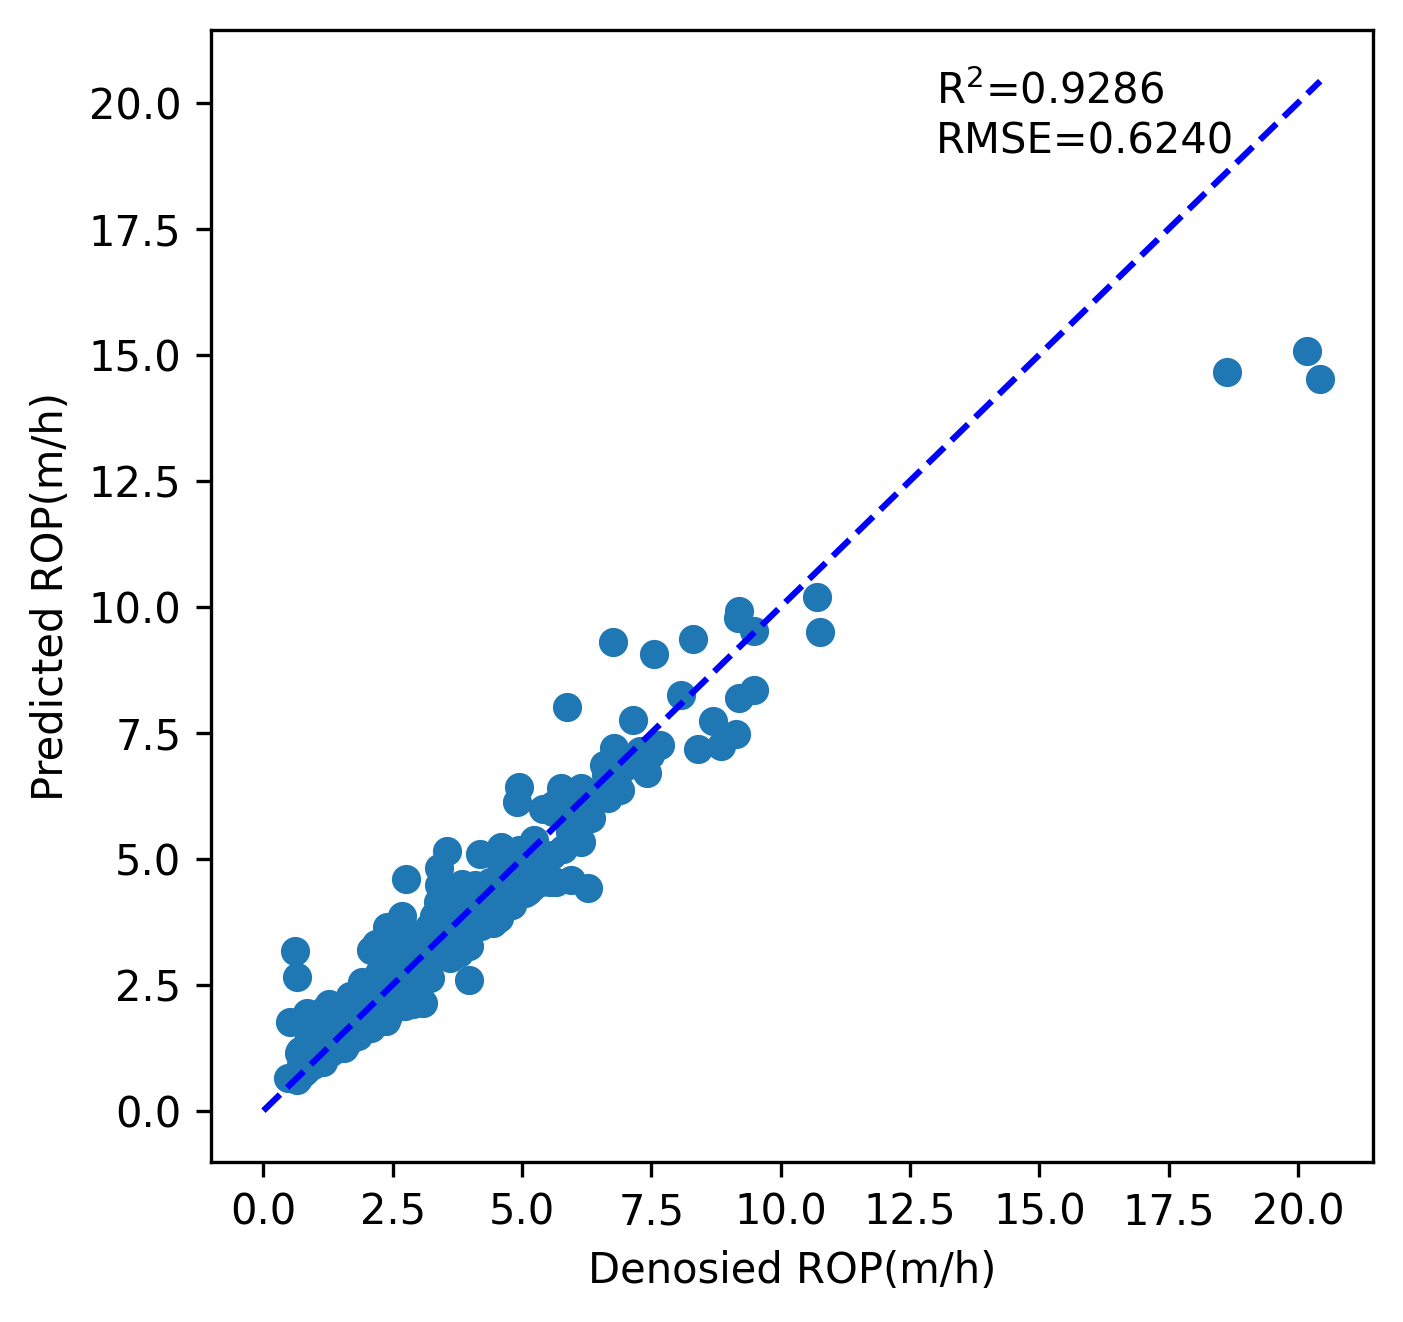

In [23]:
y_test_pred_ET_i=y_minmax.inverse_transform(y_test_pred_ET.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_ET_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_ET))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_ET_i)**0.5)
plt.savefig('et.png', dpi=300,bbox_inches='tight')
mox.file.copy('et.png', os.path.join(Context.get_output_path(), 'et.png'))

In [24]:
from sklearn.svm import SVR
SVR = SVR(kernel = 'rbf',C=1000,gamma=1)
# SVR = SVR(kernel = 'linear',C=1000,gamma=1)
# SVR=SVR()
SVR.fit(X_train, y_train)
#测试
y_test_pred_SVR = SVR.predict(X_test)
y_train_pred_SVR = SVR.predict(X_train)
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print ('The r2_score of SVR on test is', r2_score(y_test, y_test_pred_SVR))
print ('The r2_score of SVR on train is', r2_score(y_train, y_train_pred_SVR))
print('The RMSE of SVR on train is',mean_squared_error(y_train, y_train_pred_SVR)**0.5)
print('The RMSE of SVR on test is',mean_squared_error(y_test, y_test_pred_SVR)**0.5)

The r2_score of SVR on test is 0.5572255804784154
The r2_score of SVR on train is 0.6072305468966225
The RMSE of SVR on train is 0.06254628751086917
The RMSE of SVR on test is 0.07462652294971713


In [25]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_train_pred_SVR_i=y_minmax.inverse_transform(y_train_pred_SVR.reshape(-1,1))
y_test_pred_SVR_i=y_minmax.inverse_transform(y_test_pred_SVR.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_SVR_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_SVR_i)**0.5)

The RMSE of lg on train is 1.3027137846853083
The RMSE of lg on test is 1.5543208720875212


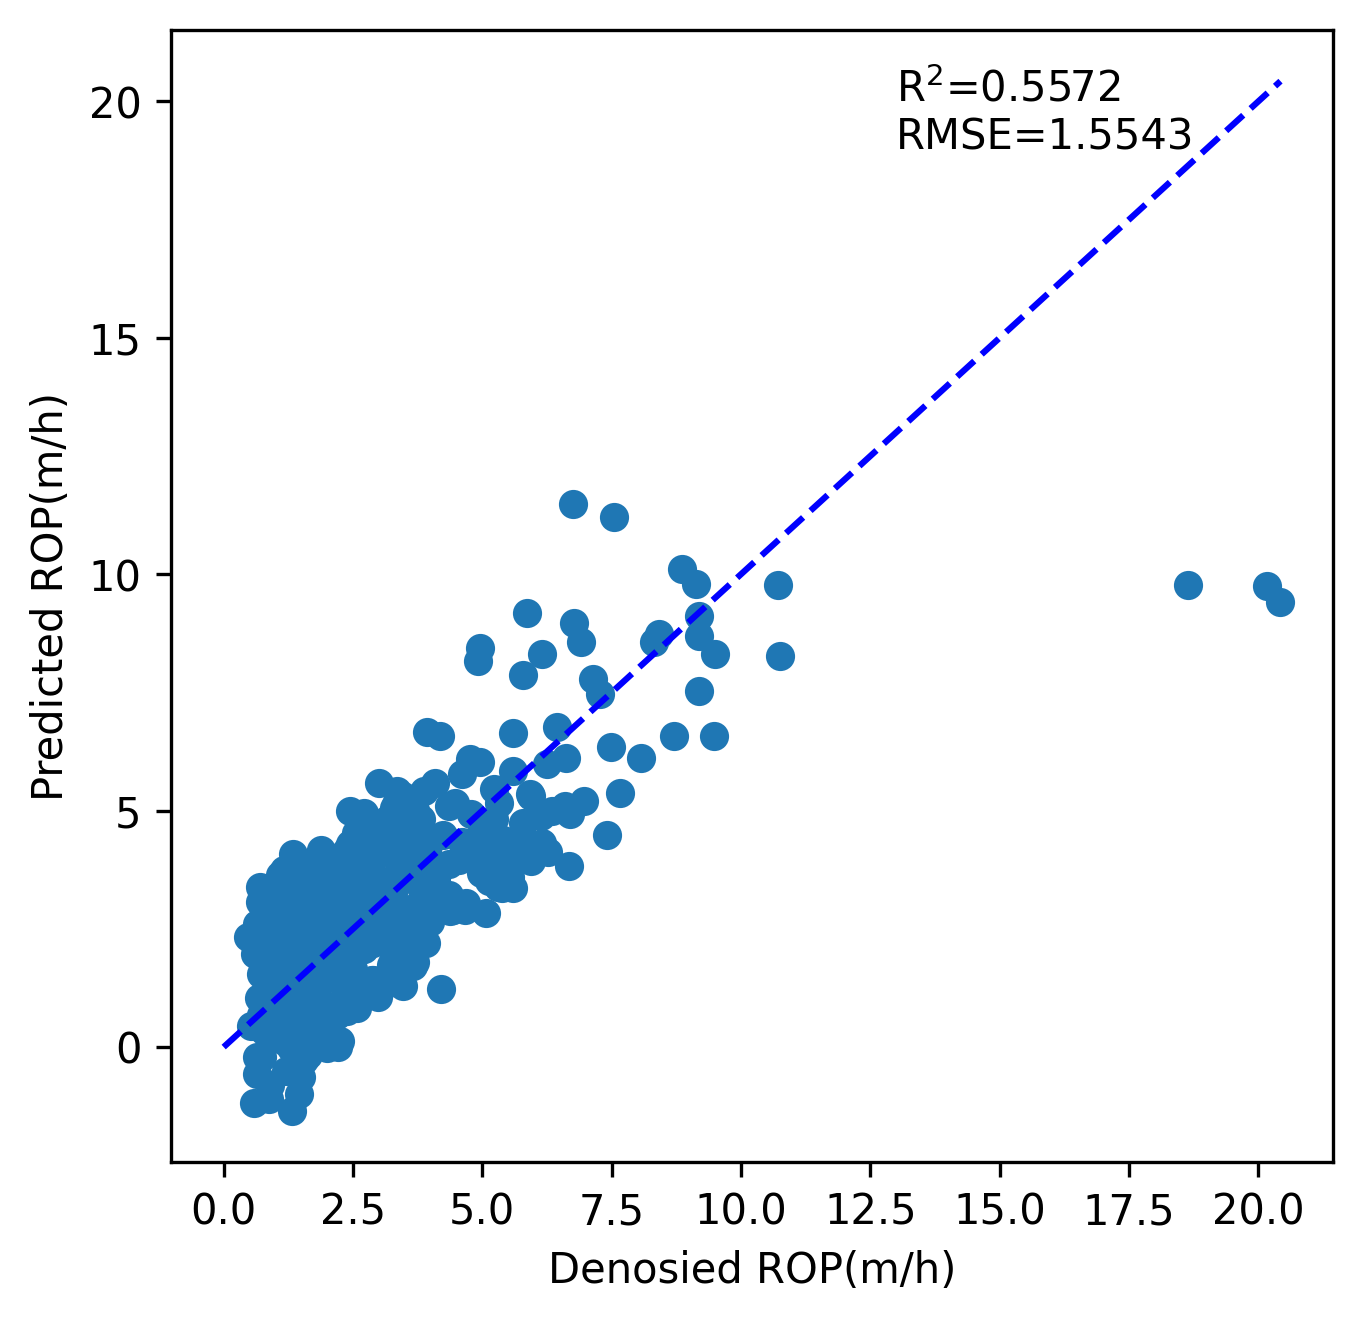

In [26]:
y_test_pred_SVR_i=y_minmax.inverse_transform(y_test_pred_SVR.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_SVR_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_SVR))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_SVR_i)**0.5)
plt.savefig('svr.png', dpi=300,bbox_inches='tight')
mox.file.copy('svr.png', os.path.join(Context.get_output_path(), 'svr.png'))

In [27]:
from lightgbm.sklearn import LGBMRegressor
params={
     'n_estimators':200,
#        'num_leaves': 35,
#     'objective': 'regression',
#     'min_data_in_leaf': 20,
    'learning_rate': 0.1,
    'max_depth': 15
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 1,
#     'metric': 'l2',
#     'num_threads': 4  
       }
LightGBM=LGBMRegressor(**params)
LightGBM.fit(X_train, y_train)
#测试
y_test_pred_LightGBM = LightGBM.predict(X_test)
y_train_pred_LightGBM =LightGBM.predict(X_train)

print ('The r2 score of lg on test is', r2_score(y_test, y_test_pred_LightGBM))
print ('The r2 score of lg on train is', r2_score(y_train, y_train_pred_LightGBM))
print('The RMSE of lgbm on train is',mean_squared_error(y_train, y_train_pred_LightGBM)**0.5)
print('The RMSE of lgbm on test is',mean_squared_error(y_test, y_test_pred_LightGBM)**0.5)

The r2 score of lg on test is 0.8778977027285467
The r2 score of lg on train is 0.9797747926965924
The RMSE of lgbm on train is 0.014193162520175839
The RMSE of lgbm on test is 0.0391889712942155


In [28]:
y_train_pred_LightGBM_i=y_minmax.inverse_transform(y_train_pred_LightGBM.reshape(-1,1))
y_test_pred_LightGBM_i=y_minmax.inverse_transform(y_test_pred_LightGBM.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_LightGBM_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_LightGBM_i)**0.5)

The RMSE of lg on train is 0.29561512280163454
The RMSE of lg on test is 0.8162277114167591


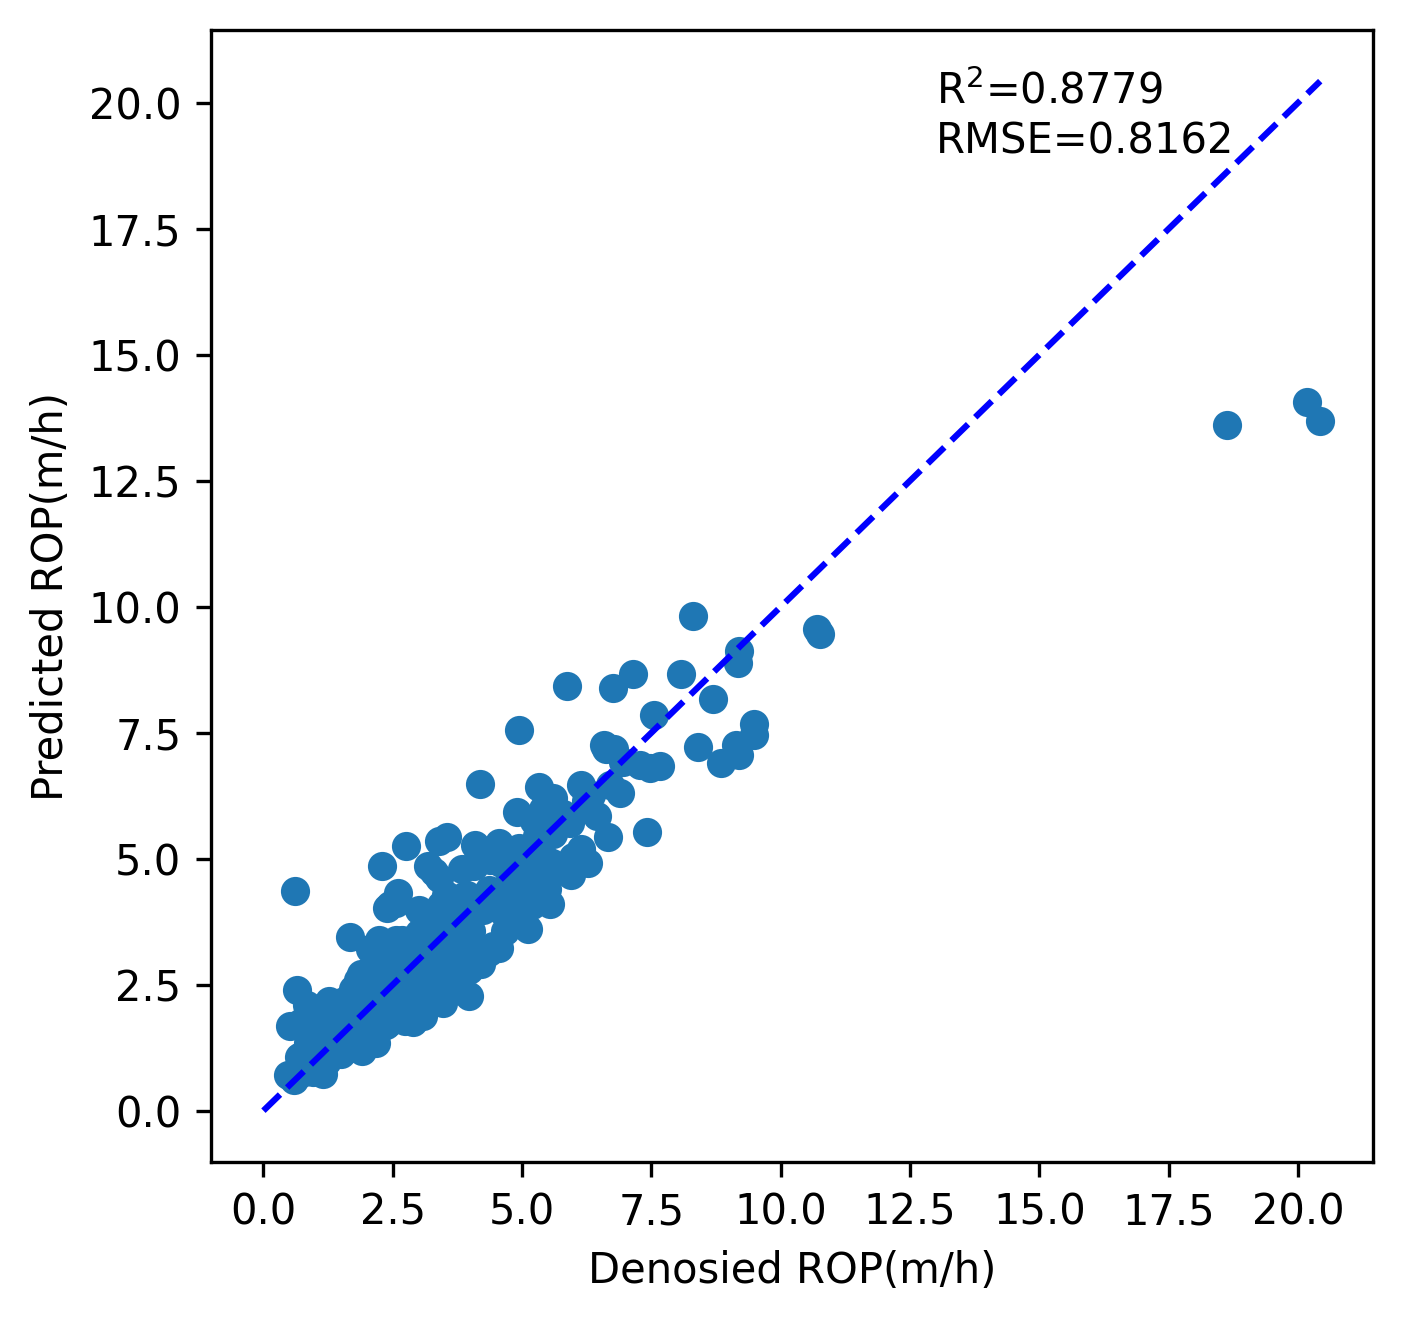

In [29]:
y_test_pred_LightGBM_i=y_minmax.inverse_transform(y_test_pred_LightGBM.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_LightGBM_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_LightGBM))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_LightGBM_i)**0.5)
plt.savefig('lg.png', dpi=300,bbox_inches='tight')
mox.file.copy('lg.png', os.path.join(Context.get_output_path(), 'lg.png'))

In [30]:
from sklearn.ensemble import RandomForestRegressor

# RF = RandomForestRegressor
RF = RandomForestRegressor(
    n_estimators=200, 
#     criterion="entropy",
    max_depth=20,    
    min_samples_split=2, 
#     min_samples_leaf=1,    
#     min_weight_fraction_leaf=0.0,    
#     max_features='auto',    
#     max_leaf_nodes=50, bootstrap=True,    
#     oob_score=False,
    random_state=42, 
#     verbose=0,    
   )
RF.fit(X_train, y_train)
#测试
y_test_pred_RF = RF.predict(X_test)
y_train_pred_RF= RF.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能
print ('The r2 score of lg on test is', r2_score(y_test, y_test_pred_RF))
print ('The r2 score of lg on train is', r2_score(y_train, y_train_pred_RF))
print('The RMSE of lg on train is',mean_squared_error(y_train, y_train_pred_RF)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test, y_test_pred_RF)**0.5)

The r2 score of lg on test is 0.8713610893643936
The r2 score of lg on train is 0.9851799560279084
The RMSE of lg on train is 0.01214947274138277
The RMSE of lg on test is 0.04022426551954672


In [31]:
y_train_pred_RF_i=y_minmax.inverse_transform(y_train_pred_RF.reshape(-1,1))
y_test_pred_RF_i=y_minmax.inverse_transform(y_test_pred_RF.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_RF_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_RF_i)**0.5)

The RMSE of lg on train is 0.2530491616166235
The RMSE of lg on test is 0.8377908147154115


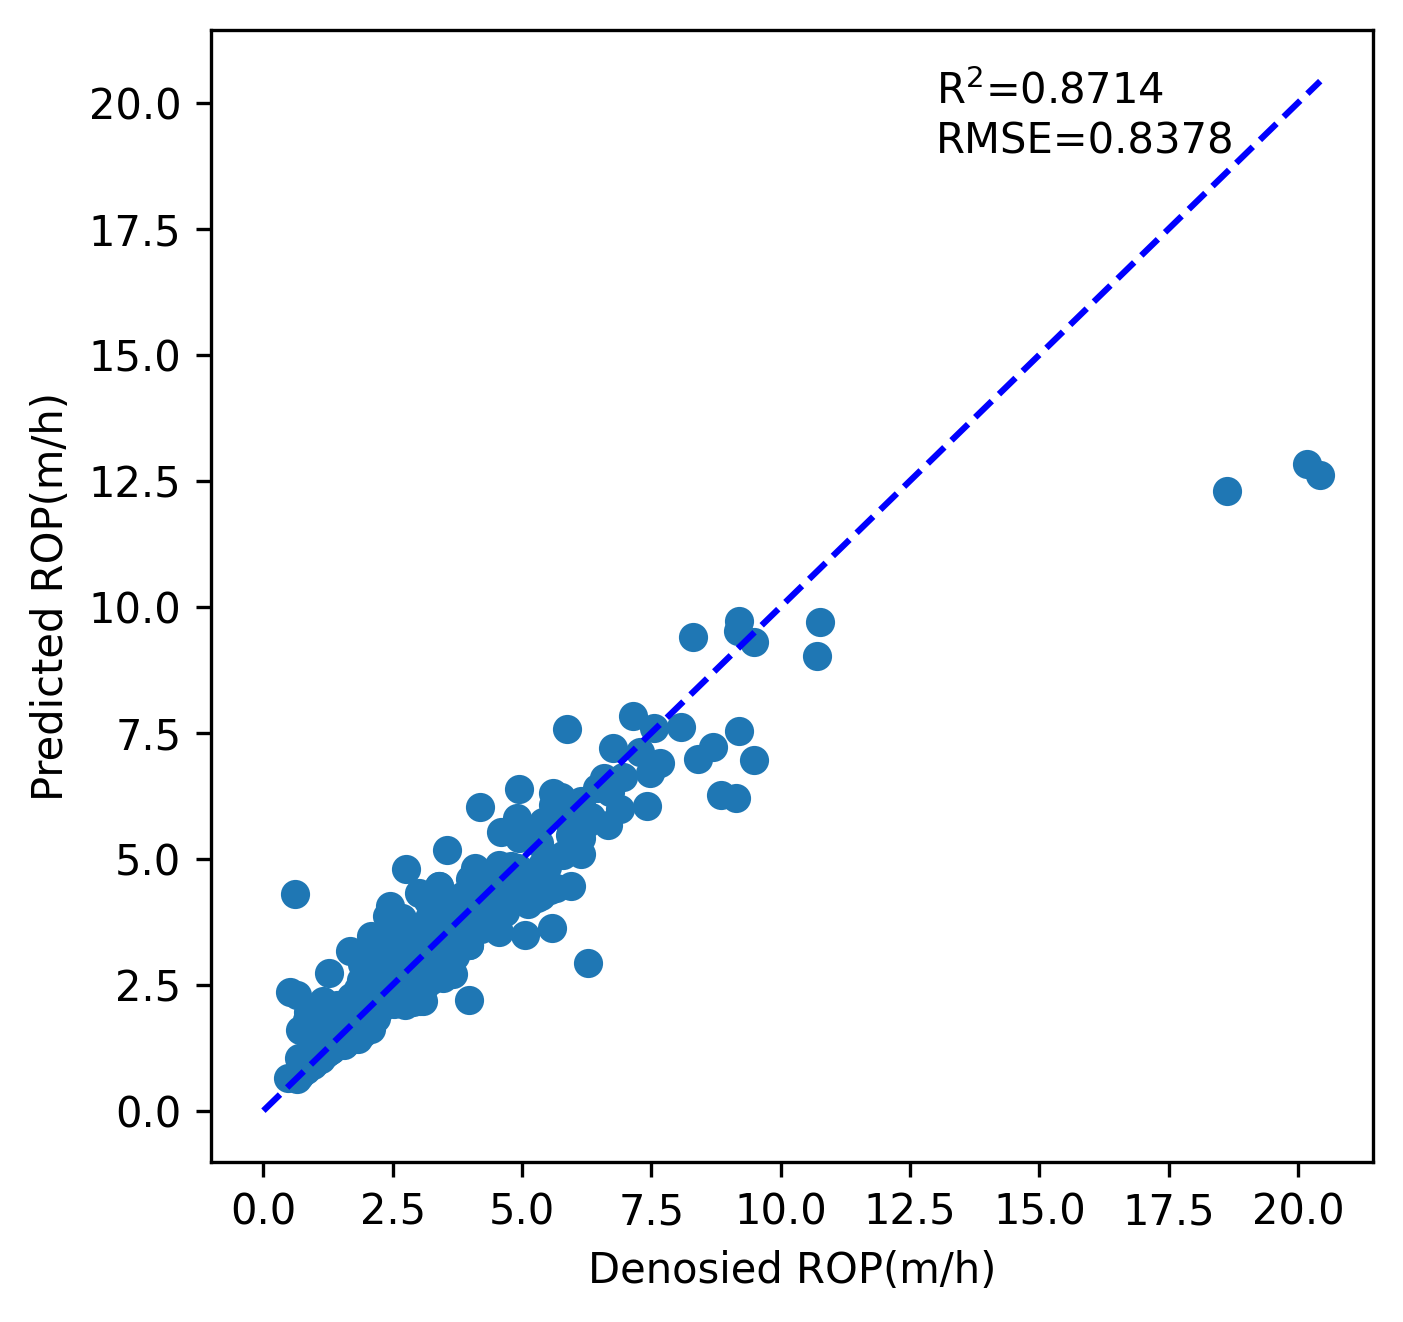

In [32]:
y_test_pred_RF_i=y_minmax.inverse_transform(y_test_pred_RF.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_RF_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_RF))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_RF_i)**0.5)
plt.savefig('rf.png', dpi=300,bbox_inches='tight')
mox.file.copy('rf.png', os.path.join(Context.get_output_path(), 'rf.png'))

In [33]:
from xgboost import XGBRegressor
XGB =XGBRegressor(n_estimators=60,random_state=42,gamma=0.00001)

XGB.fit(X_train, y_train)
#测试
y_test_pred_XGB = XGB.predict(X_test)
y_train_pred_XGB= XGB.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能

print ('The r2 score of lg on test is', r2_score(y_test, y_test_pred_XGB))
print ('The r2 score of lg on train is', r2_score(y_train, y_train_pred_XGB))
print('The RMSE of lg on train is',mean_squared_error(y_train, y_train_pred_XGB)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test, y_test_pred_XGB)**0.5)

The r2 score of lg on test is 0.8884058149294193
The r2 score of lg on train is 0.988151775814102
The RMSE of lg on train is 0.010863238548258663
The RMSE of lg on test is 0.03746474047327106


In [34]:
y_train_pred_XGB_i=y_minmax.inverse_transform(y_train_pred_XGB.reshape(-1,1))
y_test_pred_XGB_i=y_minmax.inverse_transform(y_test_pred_XGB.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_XGB_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_XGB_i)**0.5)

The RMSE of lg on train is 0.2262594957320339
The RMSE of lg on test is 0.7803154401396666


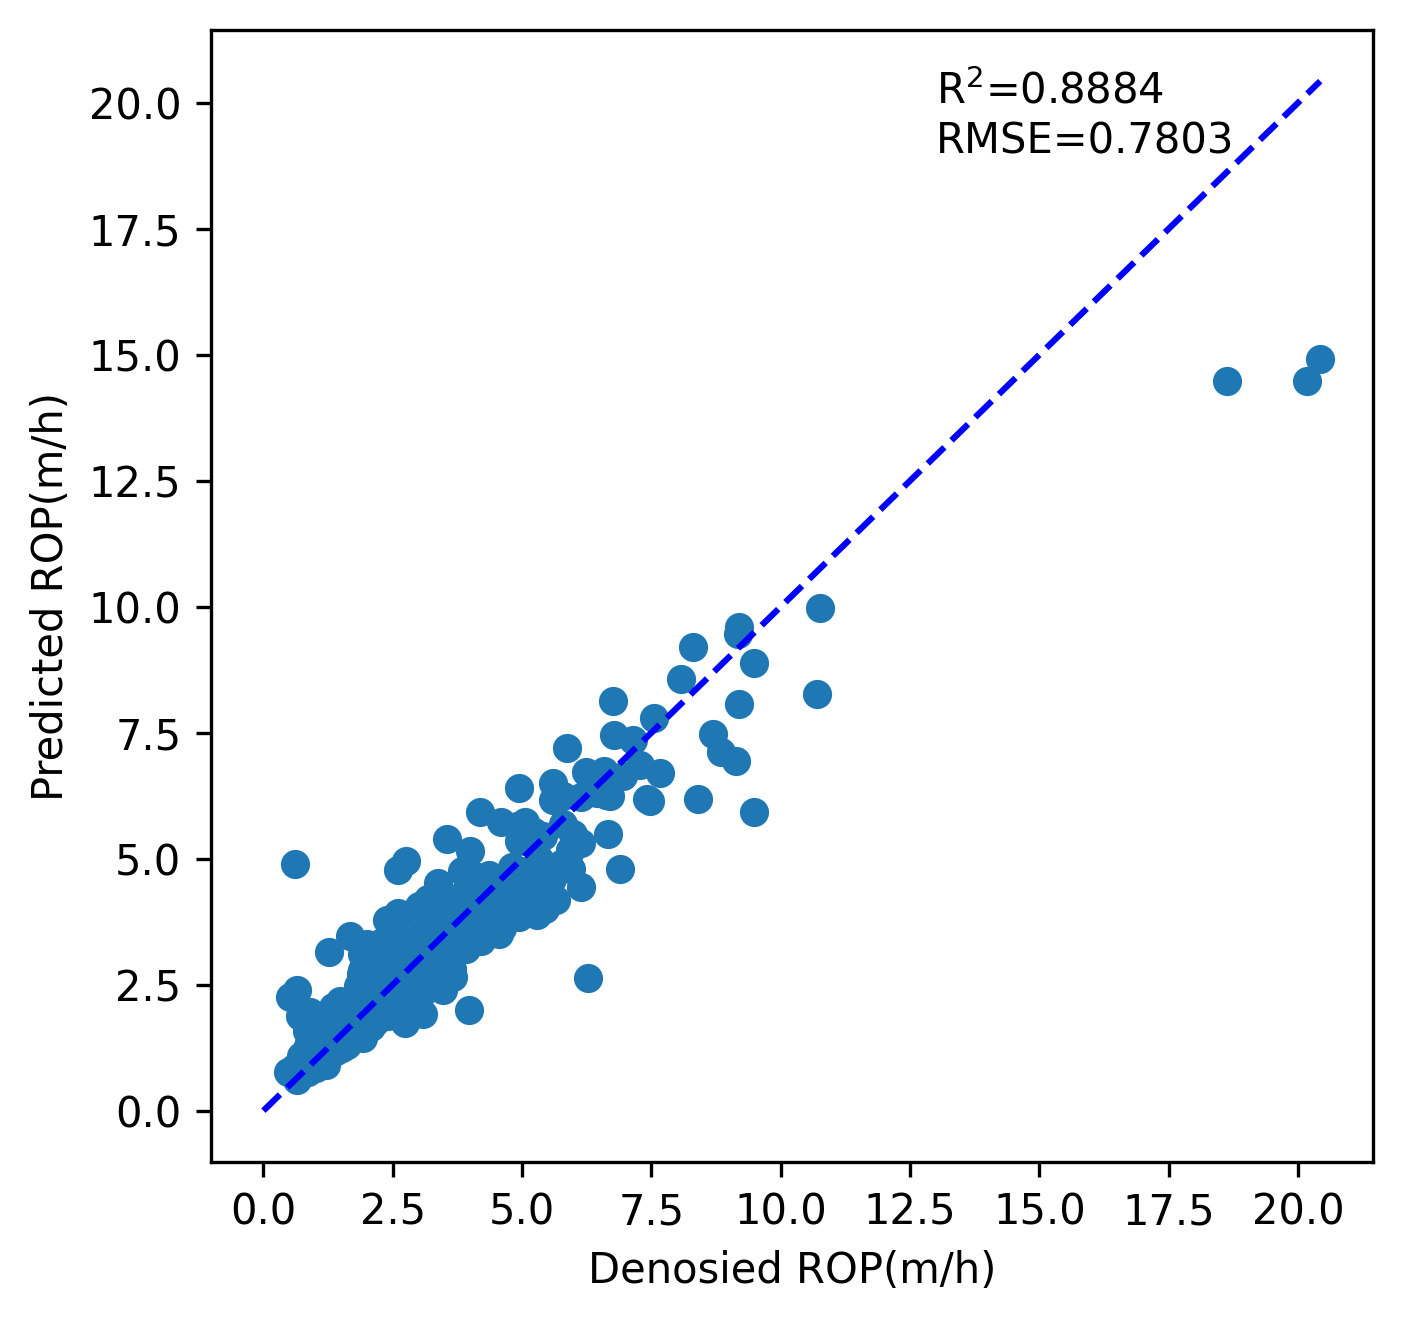

In [35]:
y_test_pred_XGB_i=y_minmax.inverse_transform(y_test_pred_XGB.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_XGB_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_XGB))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_XGB_i)**0.5)
plt.savefig('xgb.png', dpi=300,bbox_inches='tight')
mox.file.copy('xgb.png', os.path.join(Context.get_output_path(), 'xgb.png'))

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
GB =GradientBoostingRegressor(n_estimators=800,max_depth=3,learning_rate=0.1,random_state=42)

GB.fit(X_train, y_train)
#测试
y_test_pred_GB = GB.predict(X_test)
y_train_pred_GB= GB.predict(X_train)

# # 评估，使用 评价模型在测试集和训练集上的性能

print ('The r2 score of lg on test is', r2_score(y_test, y_test_pred_GB))
print ('The r2 score of lg on train is', r2_score(y_train, y_train_pred_GB))
print('The RMSE of lg on train is',mean_squared_error(y_train, y_train_pred_GB)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test, y_test_pred_GB)**0.5)

The r2 score of lg on test is 0.8663479443744329
The r2 score of lg on train is 0.9854276238215649
The RMSE of lg on train is 0.012047525987147326
The RMSE of lg on test is 0.04100055800276048


In [37]:
y_train_pred_GB_i=y_minmax.inverse_transform(y_train_pred_GB.reshape(-1,1))
y_test_pred_GB_i=y_minmax.inverse_transform(y_test_pred_GB.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_GB_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_GB_i)**0.5)

The RMSE of lg on train is 0.2509258150946839
The RMSE of lg on test is 0.8539594309367086


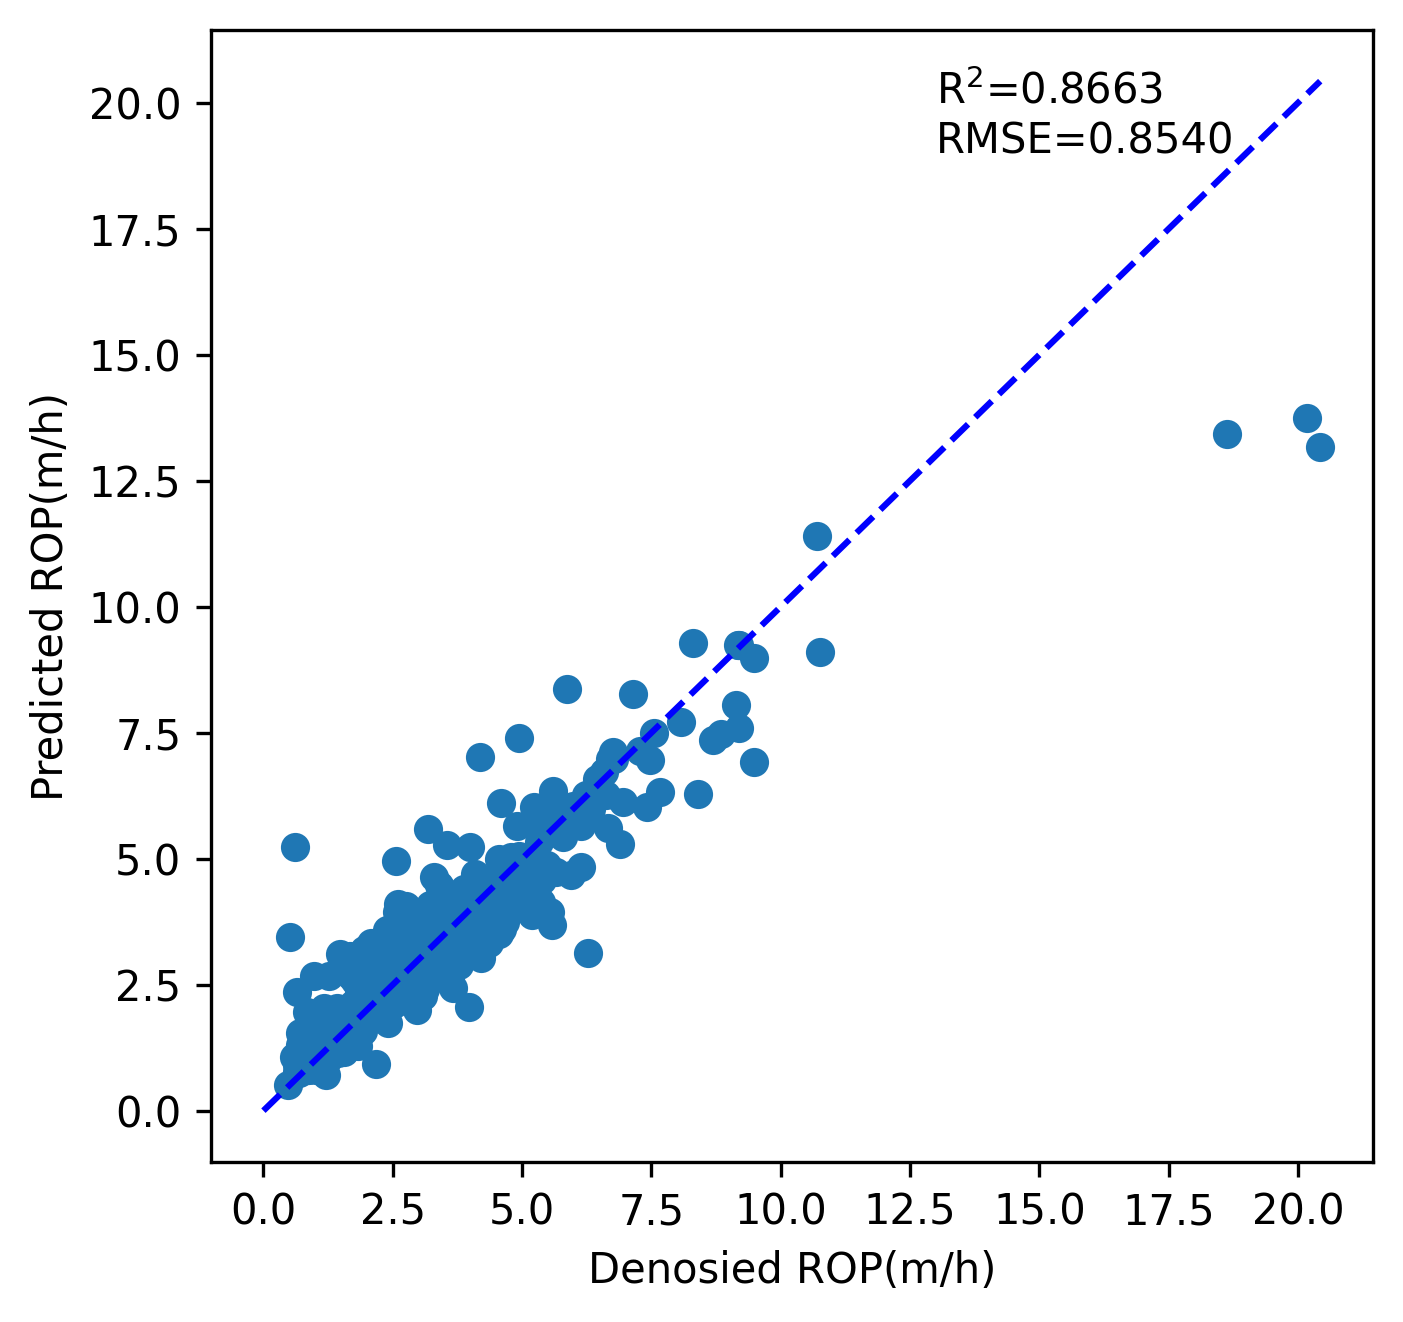

In [38]:
y_test_pred_GB_i=y_minmax.inverse_transform(y_test_pred_GB.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_GB_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_GB))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_GB_i)**0.5)
plt.savefig('gb.png', dpi=300,bbox_inches='tight')
mox.file.copy('gb.png', os.path.join(Context.get_output_path(), 'gb.png'))

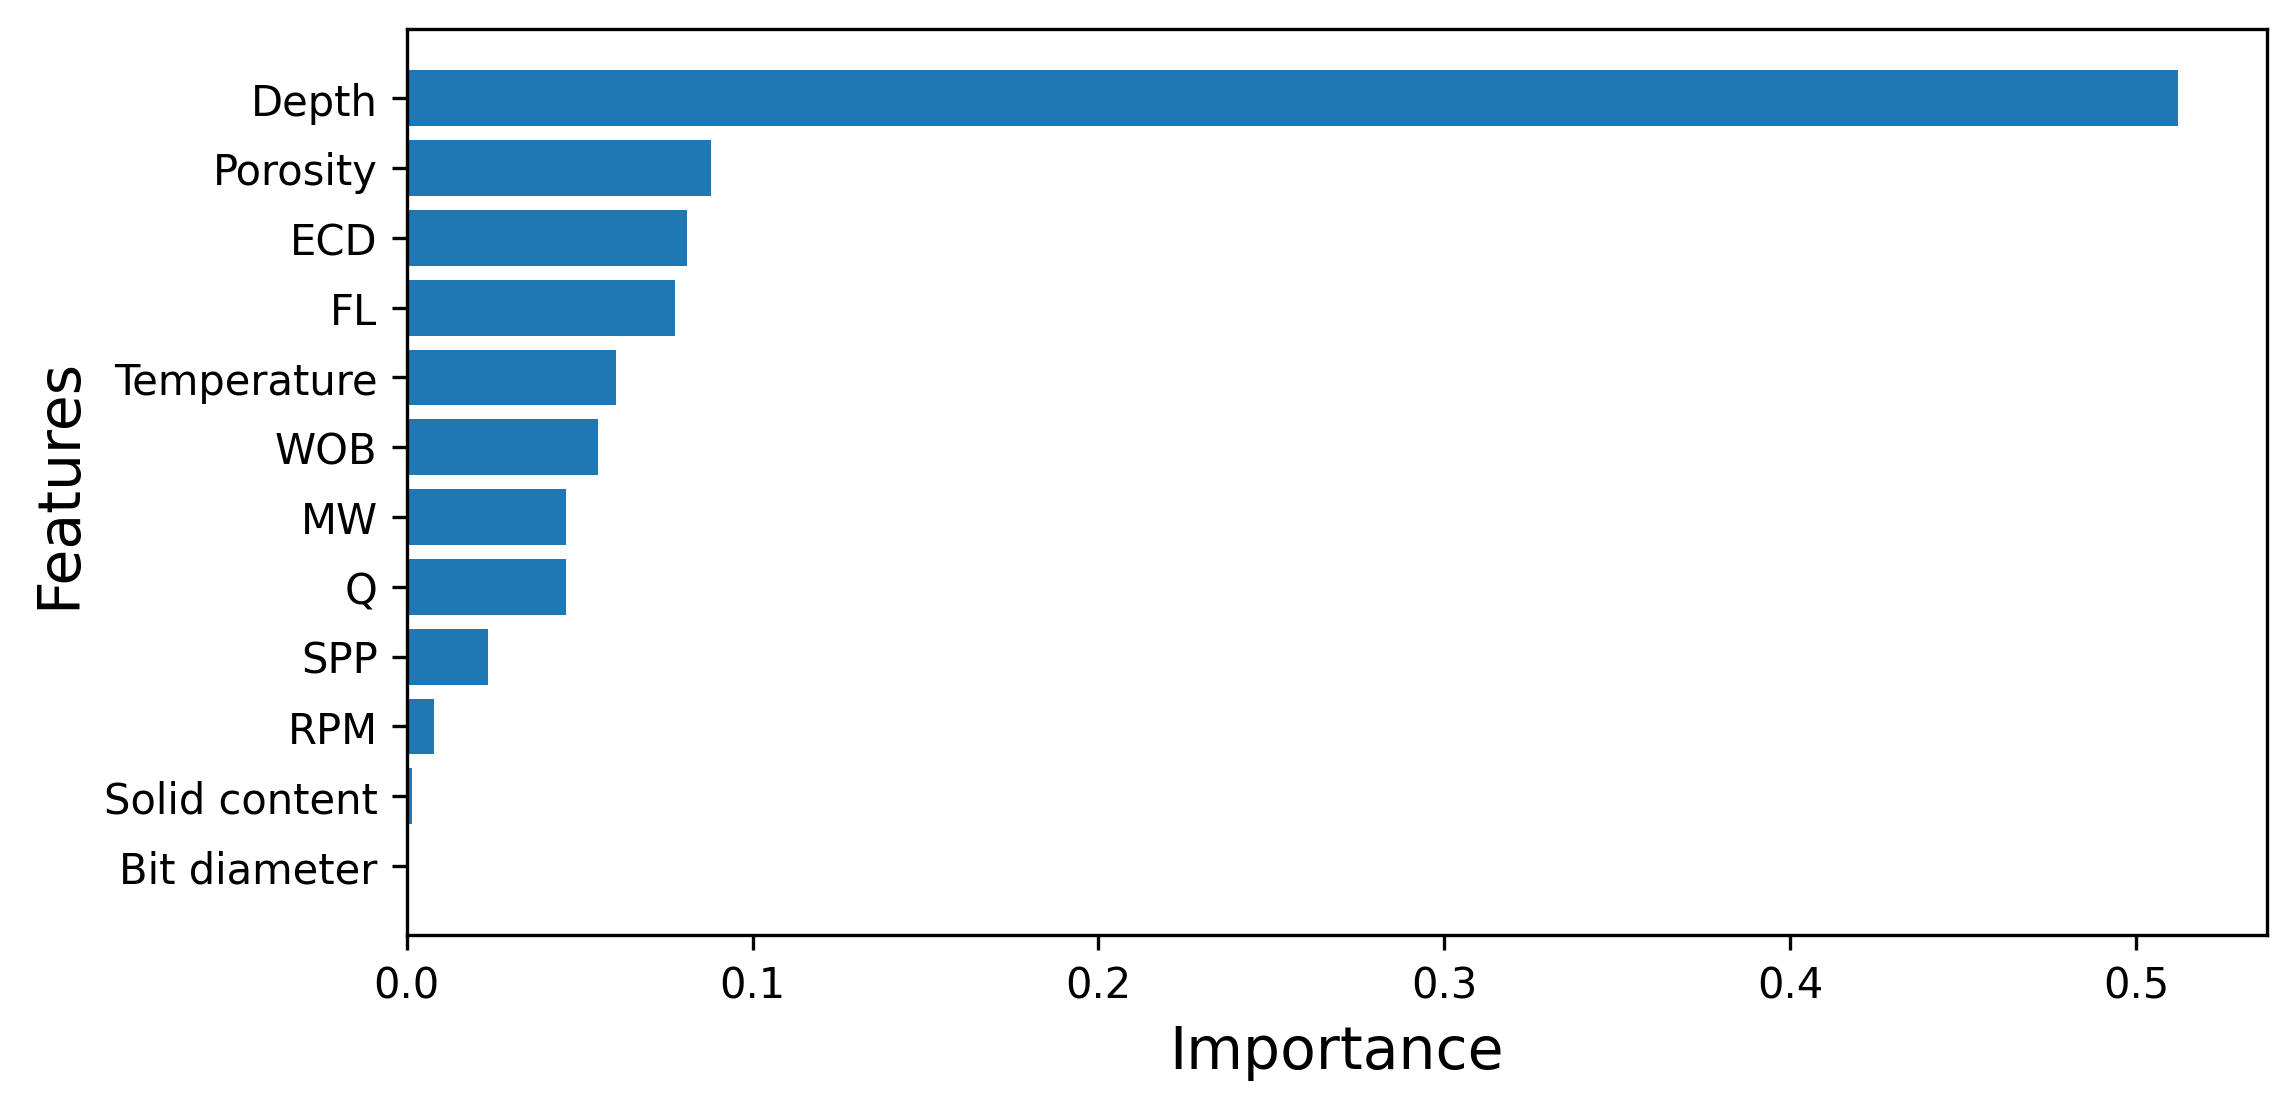

In [39]:
features_list=X.columns
df_gb = pd.DataFrame({"columns":features_list, "importance":list(GB.feature_importances_.T)})
df_gb = df_gb.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_gb['columns'] ,df_gb['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_gb.png', dpi=300,bbox_inches='tight')
mox.file.copy('df_gb.png', os.path.join(Context.get_output_path(), 'df_gb.png'))

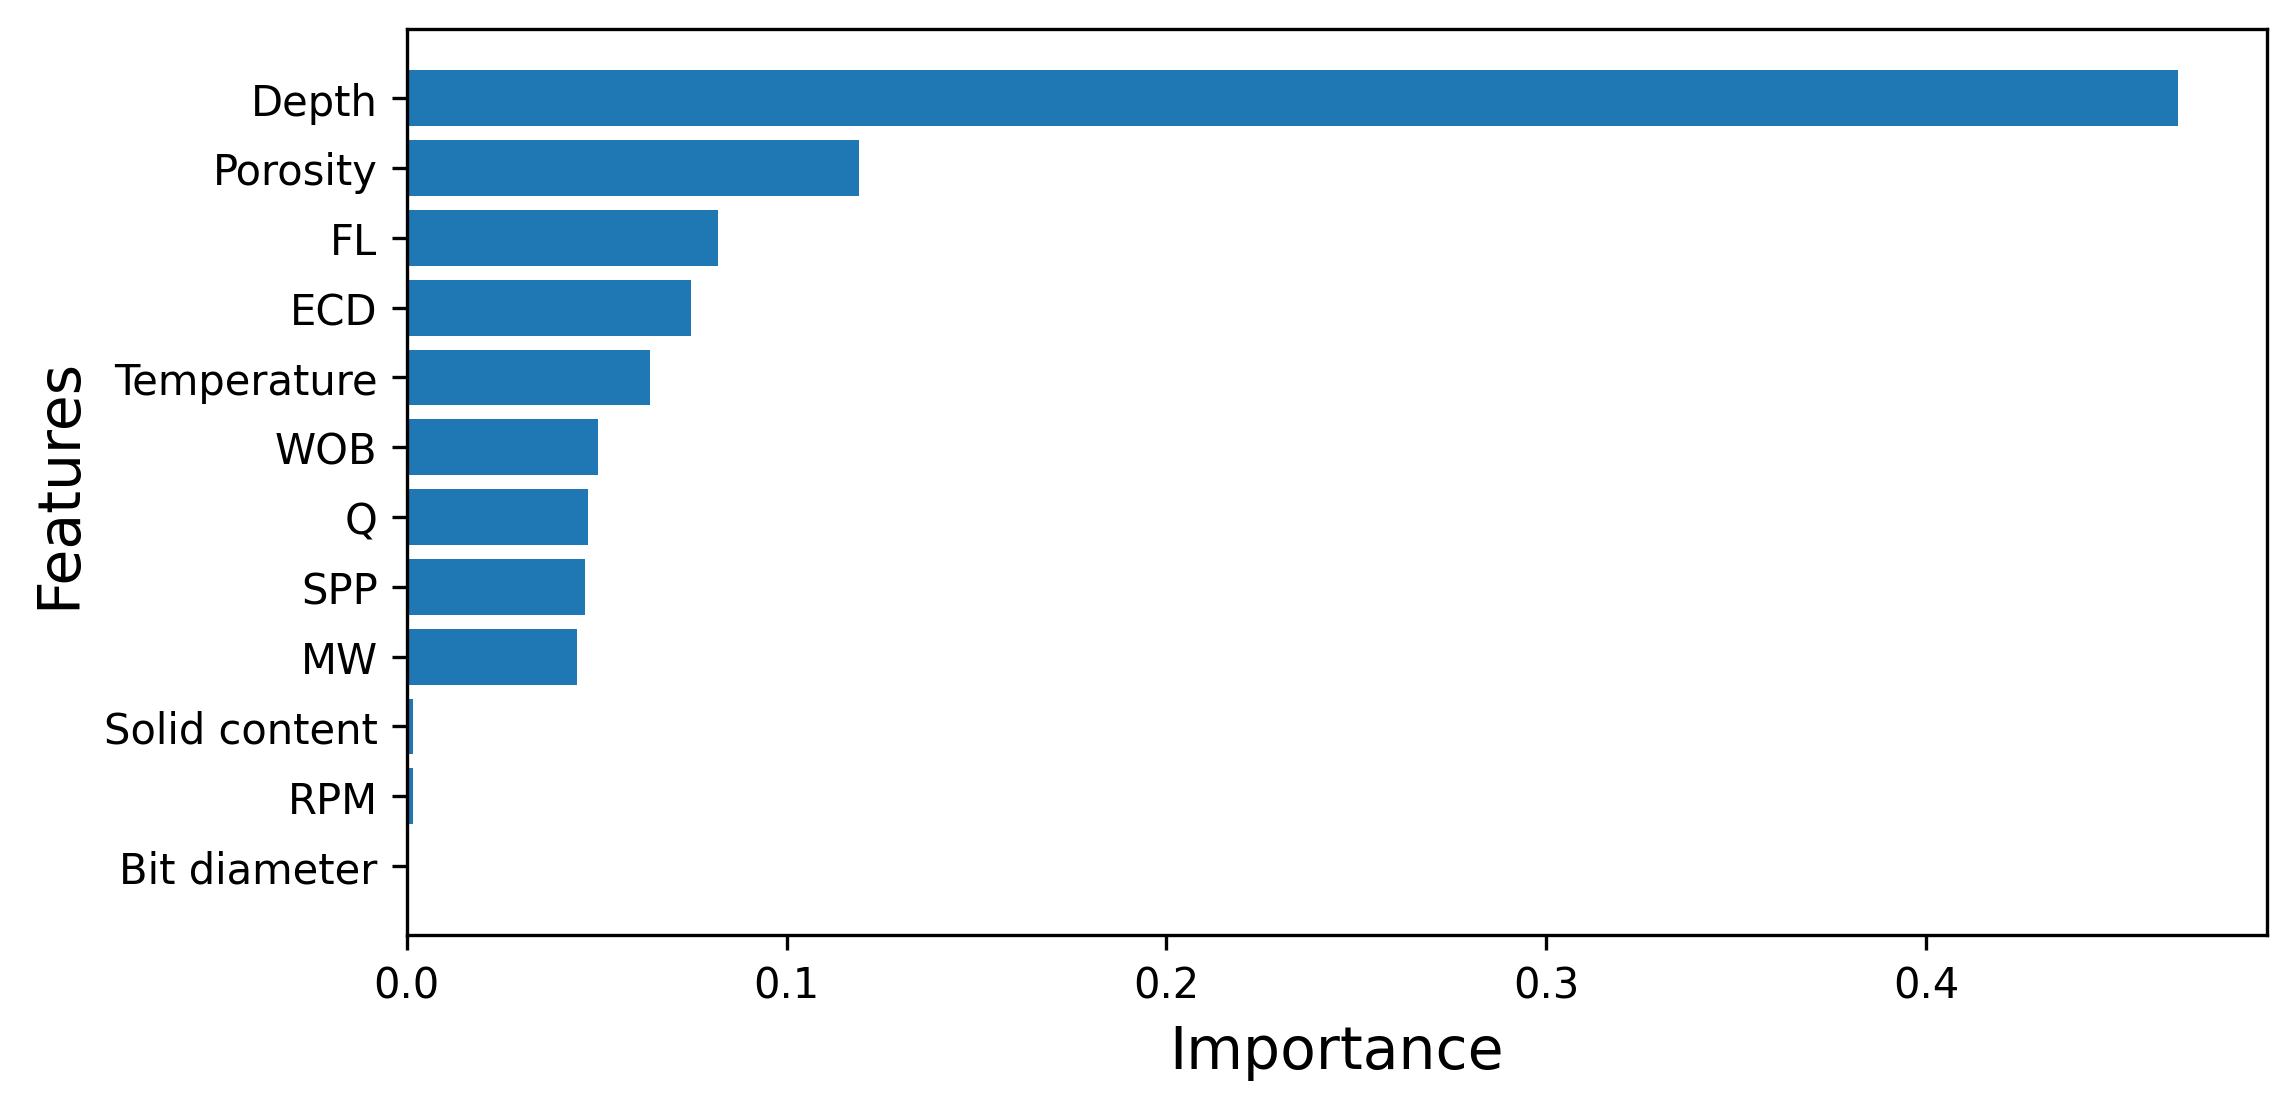

In [40]:
df_rf = pd.DataFrame({"columns":features_list, "importance":list(RF.feature_importances_.T)})
df_rf = df_rf.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_rf['columns'] ,df_rf['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_rf.png', dpi=300,bbox_inches='tight')
mox.file.copy('df_rf.png', os.path.join(Context.get_output_path(), 'df_rf.png'))

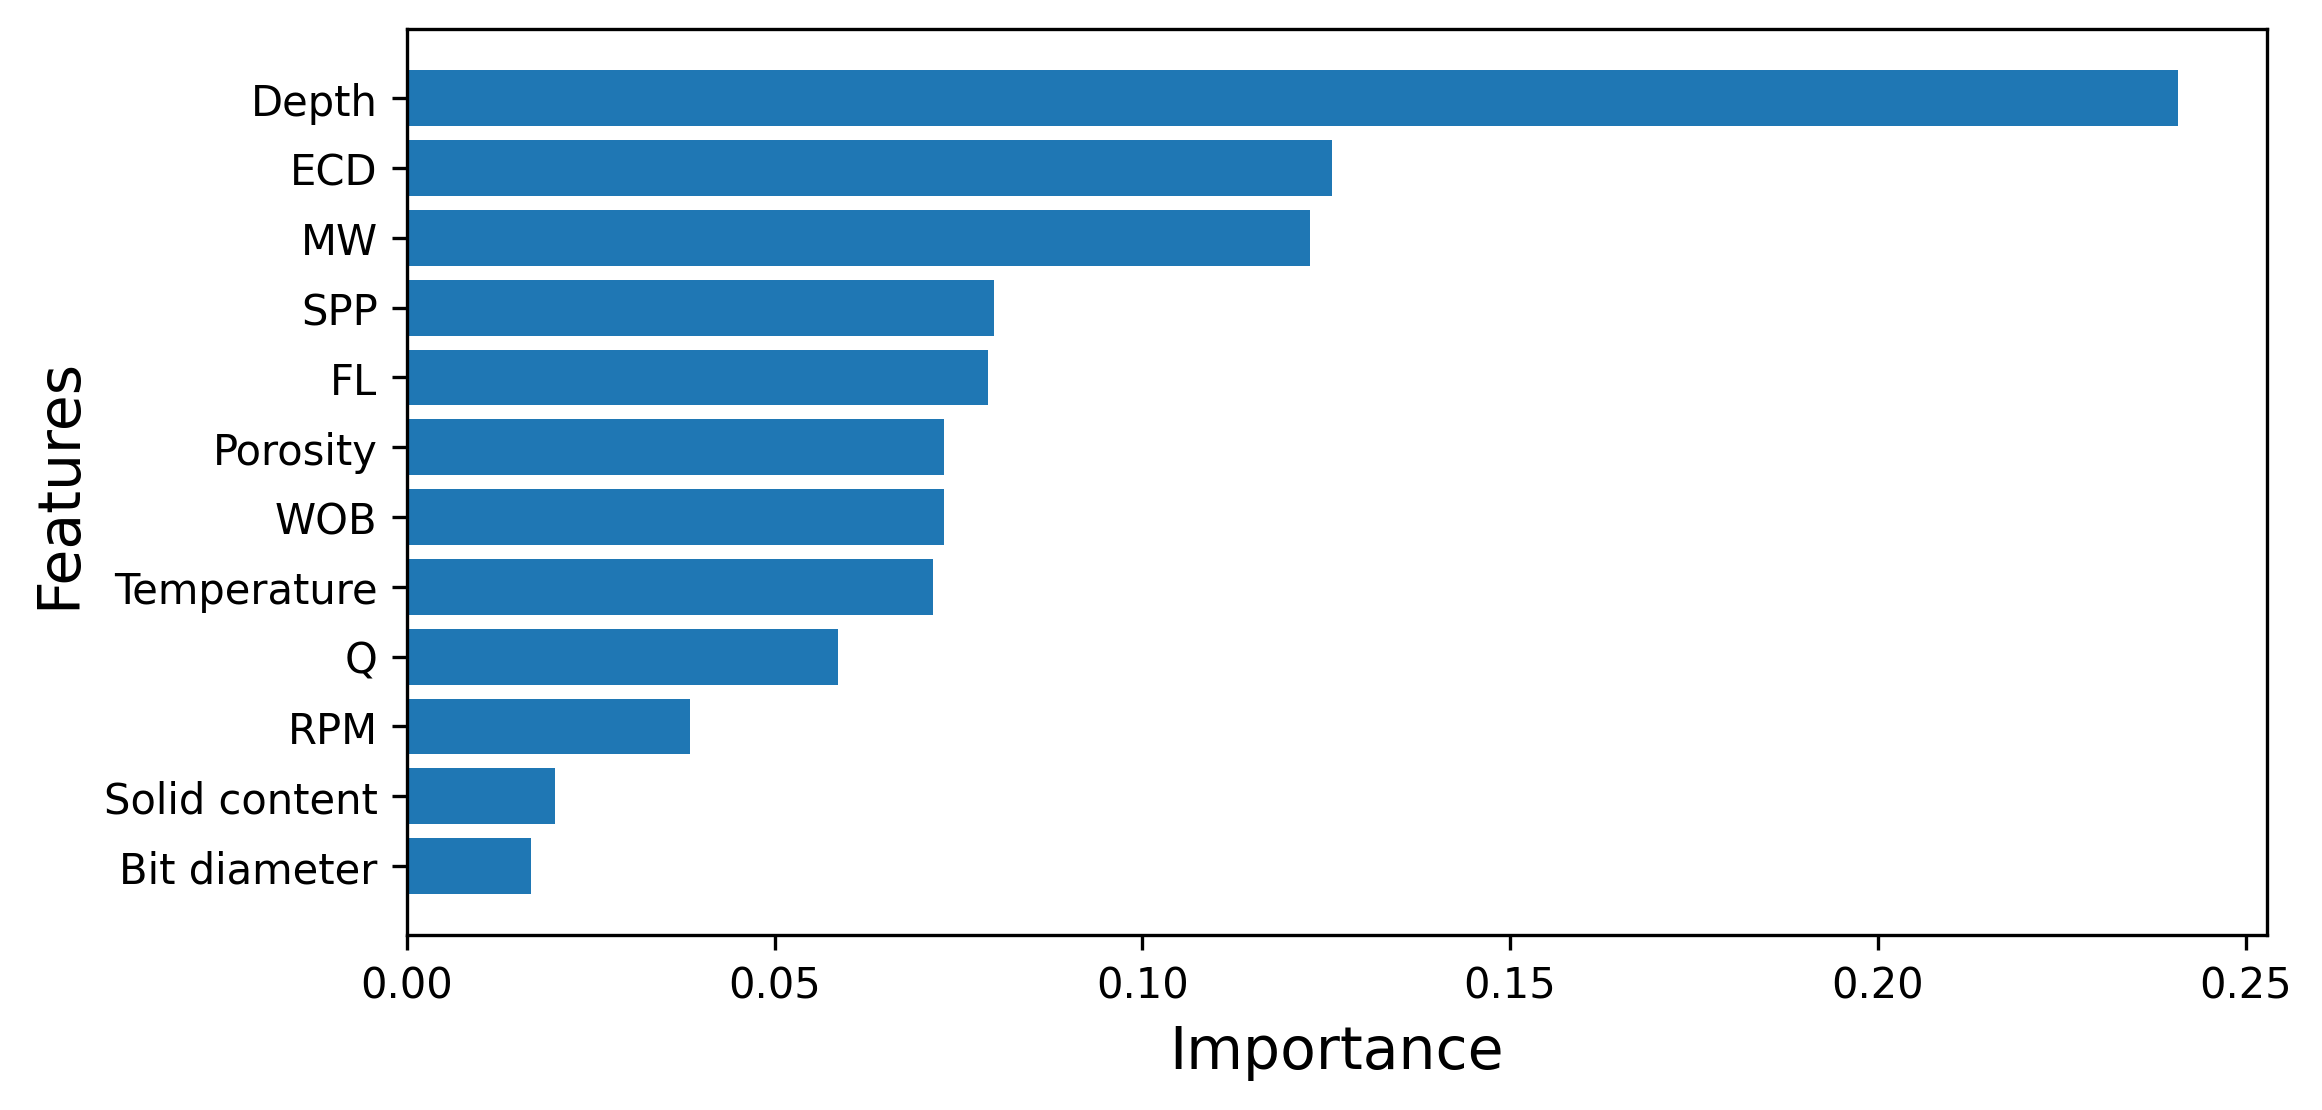

In [41]:
df_et = pd.DataFrame({"columns":features_list, "importance":list(ET.feature_importances_.T)})
df_et = df_et.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_et['columns'] ,df_et['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_et.png', dpi=300,bbox_inches='tight')
mox.file.copy('df_et.png', os.path.join(Context.get_output_path(), 'df_et.png'))

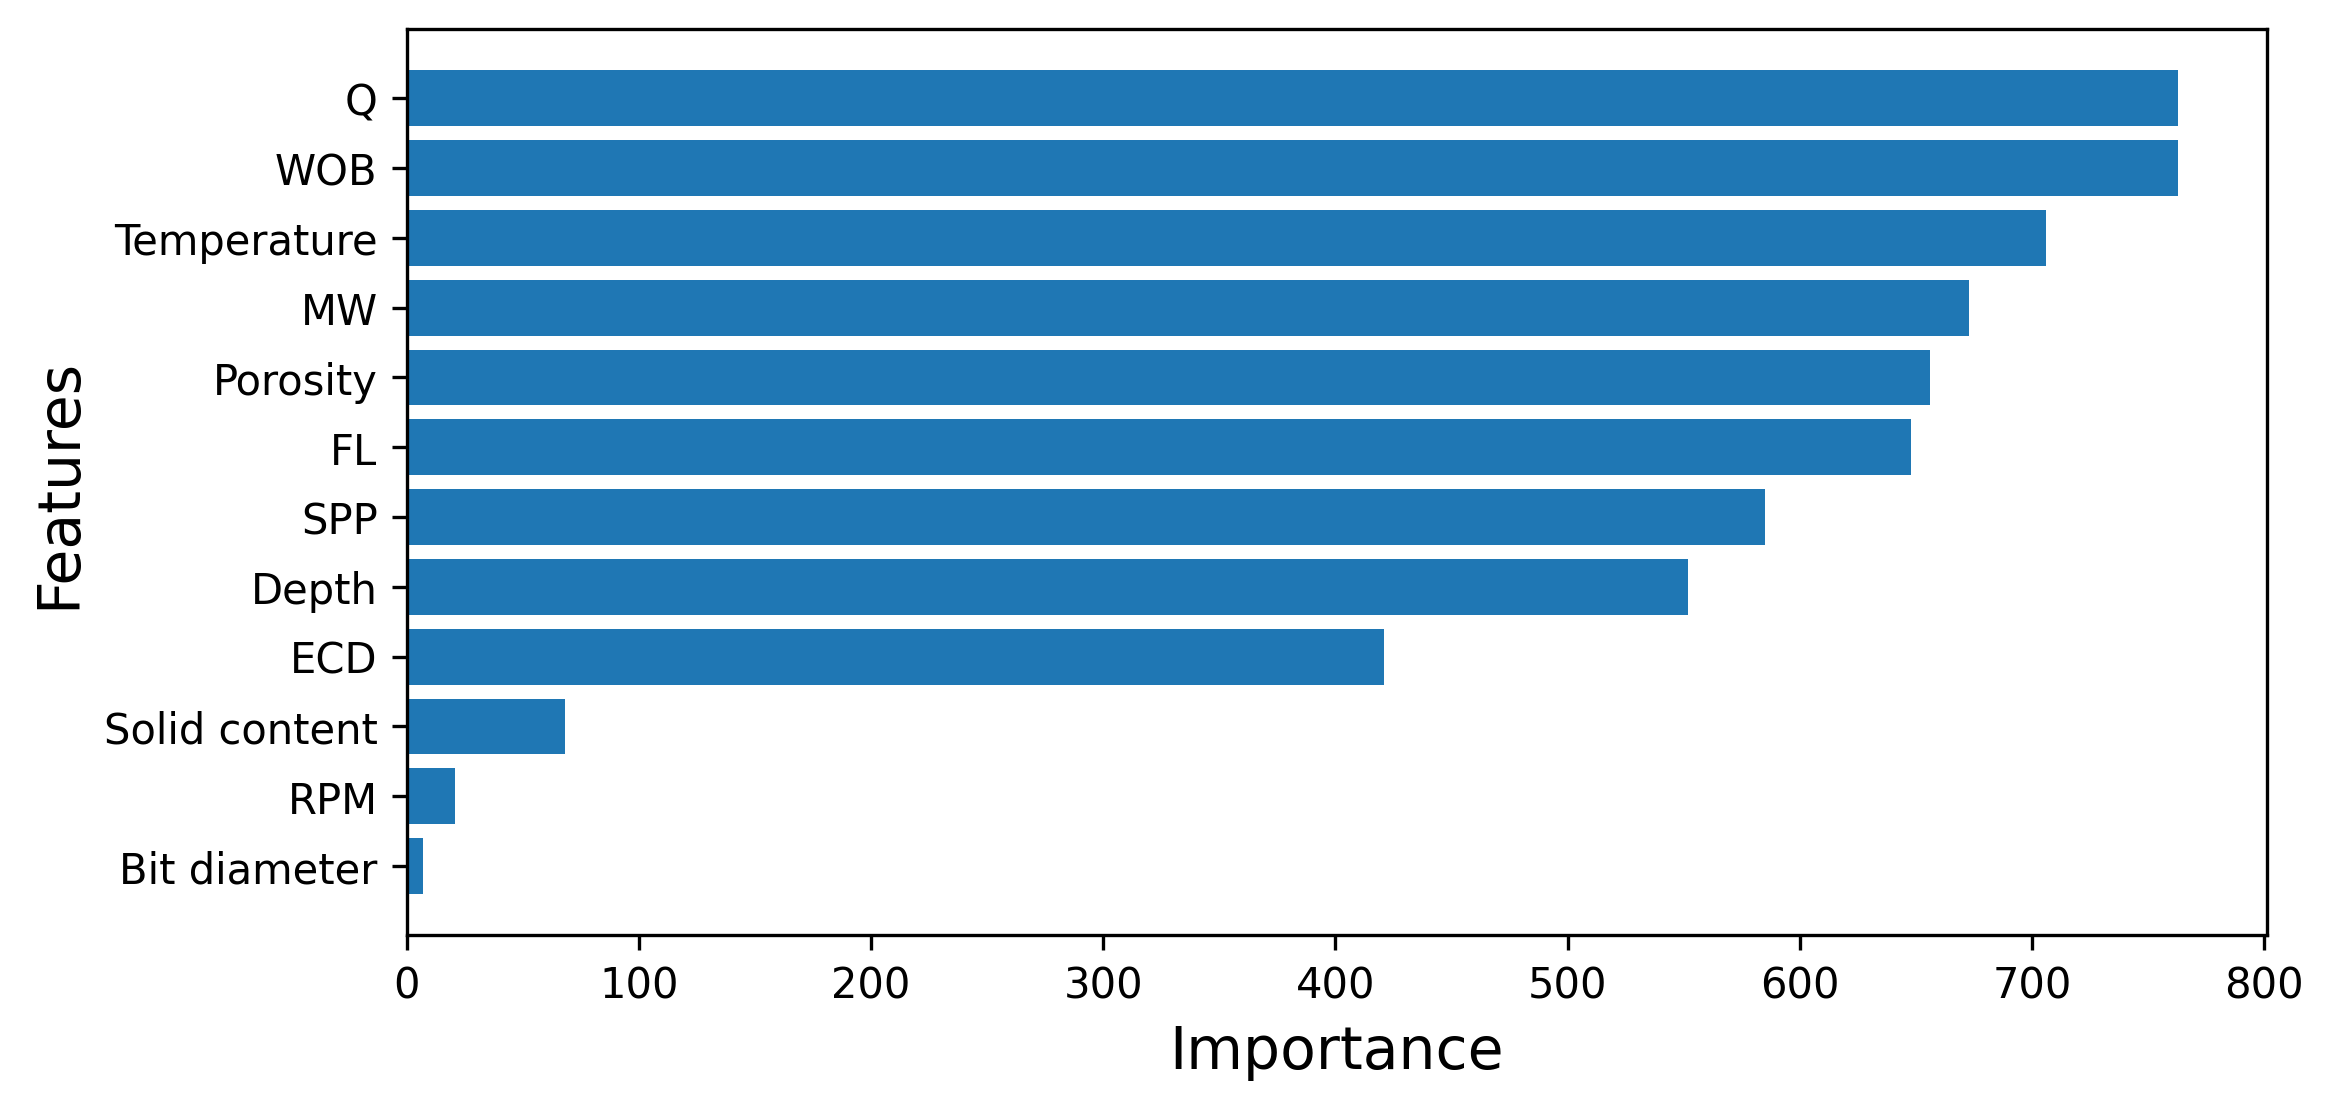

In [42]:
df_lg = pd.DataFrame({"columns":features_list, "importance":list(LightGBM.feature_importances_.T)})
df_lg = df_lg.sort_values(by=['importance'],ascending=True)
plt.figure(figsize=(8,4),dpi=300)
plt.barh(df_lg['columns'] ,df_lg['importance'])
plt.xlabel(u'Importance',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel(u'Features',fontsize=14)#设置y轴，并设定字号大小
plt.savefig('df_lg.png', dpi=300,bbox_inches='tight')
mox.file.copy('df_lg.png', os.path.join(Context.get_output_path(), 'df_lg.png'))

In [43]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
estimators = [

    ('SVR', SVR(kernel = 'rbf',C=100)),
#     ('rf1', RandomForestRegressor(n_estimators=20,random_state=42)),
#     ('ETR1', ExtraTreesRegressor(n_estimators=10,random_state=42)),
    ('RF', RandomForestRegressor(n_estimators=200,max_depth=20,random_state=42)),
    ('ET', ExtraTreesRegressor(n_estimators=300,max_depth=18,min_samples_split=2,random_state=42)),
    ('LightGBM', LGBMRegressor(n_estimators=200,max_depth=15,learning_rate= 0.1,random_state=42)),
#     ('ab', AdaBoostRegressor(random_state=42)),
    ('GB', GradientBoostingRegressor(n_estimators=800,max_depth=3,learning_rate= 0.1,random_state=33))
    
]
stacked = StackingRegressor(
    estimators=estimators,
#     final_estimator=MLPRegressor(solver='adam', hidden_layer_sizes=(50,20), learning_rate= 'adaptive',random_state=1),
#     final_estimator=RidgeCV(),
    cv=5,
#     final_estimator=LassoCV()
#     final_estimator=LinearSVR()
    final_estimator=XGBRegressor(n_estimators=60,random_state=42,gamma=0.00001),
#     passthrough=True
)

stack_r2_test=stacked.fit(X_train, y_train).score(X_test, y_test)
stack_r2_train=stacked.score(X_train, y_train)
print('stack_r2_test',stack_r2_test)
print('stack_r2_train',stack_r2_train)

stack_r2_test 0.9520778466557338
stack_r2_train 0.9809138667678156


In [44]:
y_test_pred_s=stacked.predict(X_test)
y_train_pred_s=stacked.predict(X_train)
print ('The r2 score of lg on test is', r2_score(y_test, y_test_pred_s))
print ('The r2 score of lg on train is', r2_score(y_train, y_train_pred_s))
print('The RMSE of lg on train is',mean_squared_error(y_train, y_train_pred_s)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test, y_test_pred_s)**0.5)

The r2 score of lg on test is 0.9520778466557338
The r2 score of lg on train is 0.9809138667678156
The RMSE of lg on train is 0.013787694768025608
The RMSE of lg on test is 0.0245510521163545


In [45]:
y_train_pred_s_i=y_minmax.inverse_transform(y_train_pred_s.reshape(-1,1))
y_test_pred_s_i=y_minmax.inverse_transform(y_test_pred_s.reshape(-1,1))
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
print('The RMSE of lg on train is',mean_squared_error(y_train_i, y_train_pred_s_i)**0.5)
print('The RMSE of lg on test is',mean_squared_error(y_test_i, y_test_pred_s_i)**0.5)

The RMSE of lg on train is 0.2871700295879831
The RMSE of lg on test is 0.5113491985684907


In [46]:
y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))

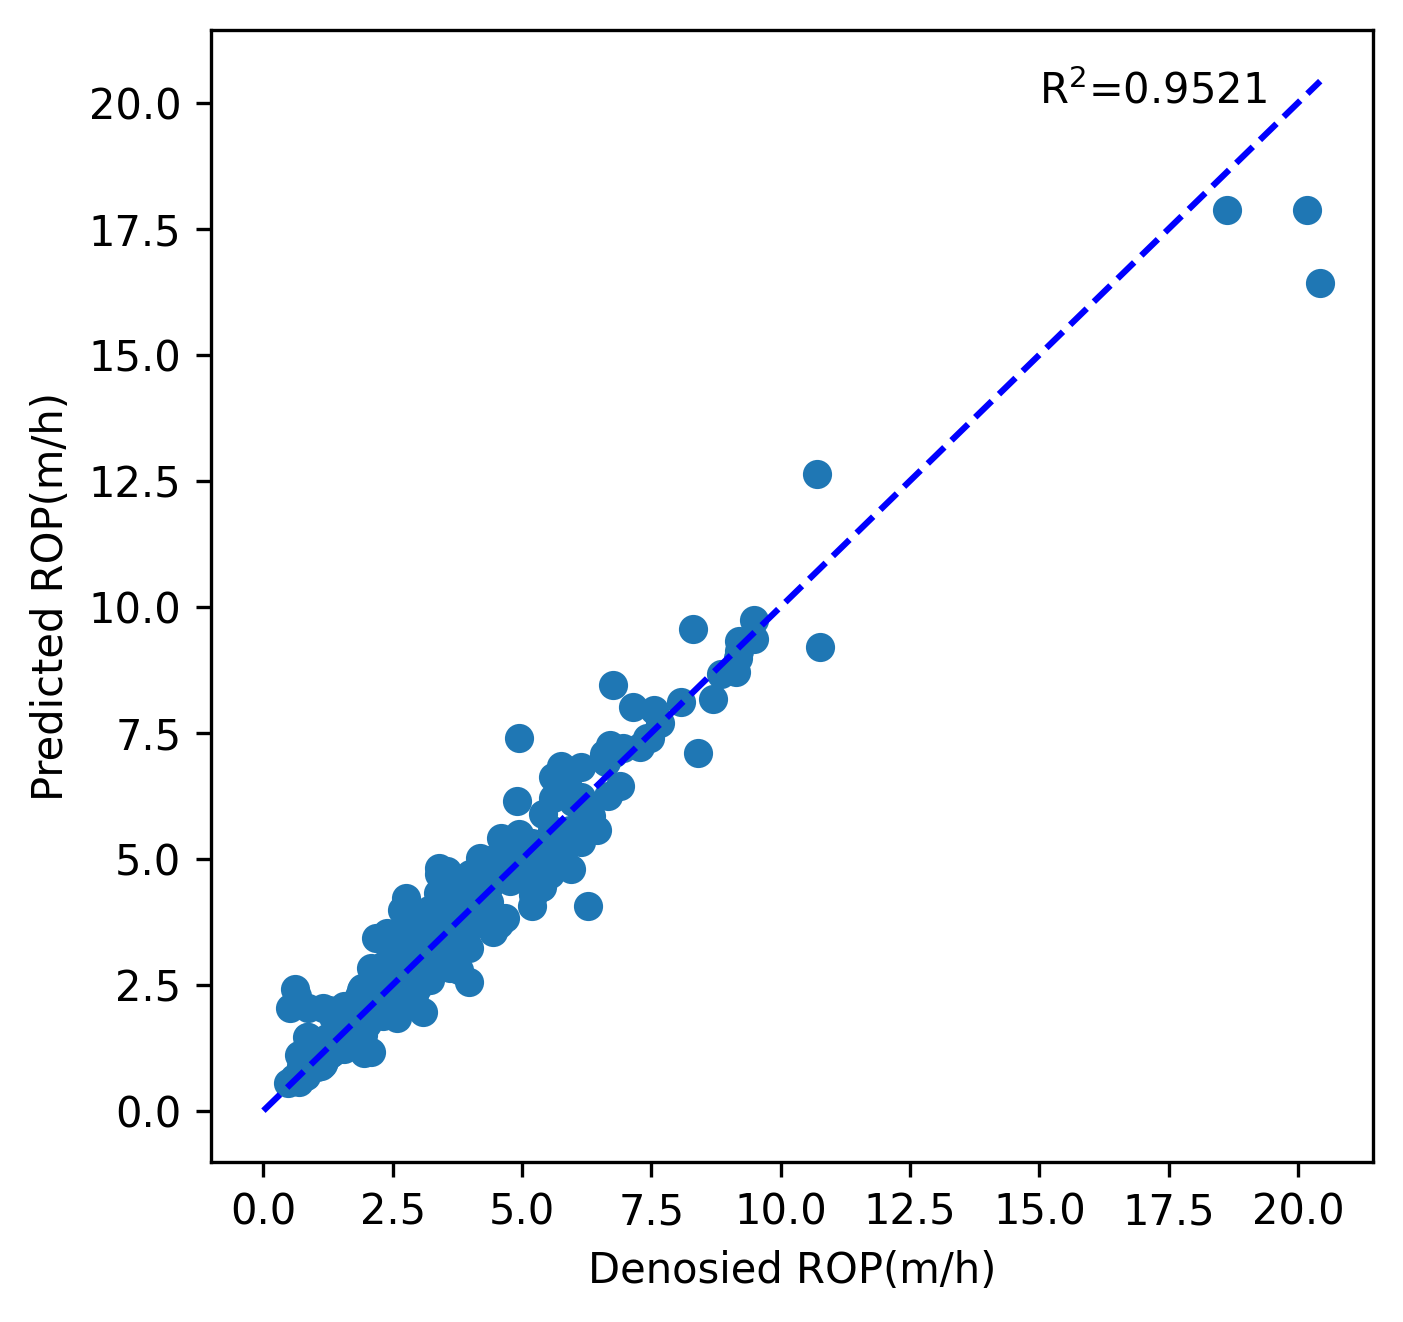

In [47]:
y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
y_test_max=y_test_i.max()
y_test_pred_s_i=y_minmax.inverse_transform(y_test_pred_s.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_test_i,y_test_pred_s_i)
plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Denosied ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
plt.text(15.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_s))
plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_GB_i)**0.5)
plt.savefig('stack.png', dpi=300,bbox_inches='tight')
mox.file.copy('stack.png', os.path.join(Context.get_output_path(), 'stack.png'))

In [48]:
from sklearn.model_selection import KFold
#Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 10 # set folds for out-of-fold prediction

kf = KFold( NFOLDS,shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
#         params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
#         print(self.clf.fit(x,y).feature_importances_)
        return self.clf.fit(x,y).feature_importances_
    
    
# Class to extend XGboost classifer

In [49]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

#     for i, (train_index, test_index) in enumerate(kf):
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_train.iloc[test_index]
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [50]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_1_params = {
#     'n_jobs': -1,
    'n_estimators': 200,
# #      'warm_start': True, 
# #      #'max_features': 0.2,
    'max_depth': 20,
#     'min_samples_leaf': 2,
# #     'max_features' : 'sqrt',
#     'verbose': 0
    'random_state':42,
}
rf_2_params = {
#     'n_jobs': -1,
    'n_estimators': 10,
# #      'warm_start': True, 
# #      #'max_features': 0.2,
# #     'max_depth': 6,
#     'min_samples_leaf': 2,
# #     'max_features' : 'sqrt',
#     'verbose': 0
    'random_state':42,
}
# Extra Trees Parameters
et_1_params = {
#     'n_jobs': -1,
    'n_estimators':10,
# #     #'max_features': 0.5,
# #     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'verbose': 0,
    'random_state':42, 
}
et_2_params = {
#     'n_jobs': -1,
    'n_estimators':300,
# #     #'max_features': 0.5,
    'max_depth': 18,
#     'min_samples_leaf': 2,
#     'verbose': 0,
    'random_state':42, 
}
# AdaBoost parameters
ada_params = {
#     'n_estimators': 500,
#     'learning_rate' : 0.75
    'random_state':42, 
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 800,
#      #'max_features': 0.2,
#     'max_depth': 5,
#     'min_samples_leaf': 2,
#     'verbose': 0
   'random_state':42,
#
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    'C' : 10
#     
}
xgb_params = {
'objective':'reg:squarederror'
    }
lgbm_params = {
    'n_estimators':200,
    'max_depth':15,
#     'learning_rate':0.1,
 'random_state':42,
    }

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
# Create 5 objects that represent our 4 models
rf_1 = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_1_params)
# rf_2 = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_2_params)
# et_1 = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_1_params)
et_2 = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_2_params)
# ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
svr = SklearnHelper(clf=SVR, seed=SEED, params=svc_params)
lgbm = SklearnHelper(clf=LGBMRegressor, seed=SEED, params=lgbm_params)
# xgb= SklearnHelper(clf=XGBRegressor, seed=SEED, params=svc_params)

In [52]:
# Create our OOF train and test predictions. These base results will be used as new features
# et_1_oof_train, et_1_oof_test = get_oof(et_1, X_train, y_train, X_test) # Extra Trees
et_2_oof_train, et_2_oof_test = get_oof(et_2, X_train, y_train, X_test) # Extra Trees
rf_1_oof_train, rf_1_oof_test = get_oof(rf_1,X_train, y_train, X_test) # Random Forest
# rf_2_oof_train, rf_2_oof_test = get_oof(rf_2,X_train, y_train, X_test) # Random Forest
# ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svr,X_train, y_train, X_test) # Support Vector Classifier
# xgb_oof_train, xgb_oof_test = get_oof(xgb,X_train, y_train, X_test)
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm,X_train, y_train, X_test)

In [53]:
# x_train = np.concatenate((  et_1_oof_train,et_2_oof_train,rf_1_oof_train,rf_2_oof_train, ada_oof_train, gb_oof_train), axis=1)
# x_test = np.concatenate(( et_1_oof_test,et_2_oof_test, rf_1_oof_test, rf_2_oof_test, ada_oof_test, gb_oof_test), axis=1)
from sklearn.linear_model import LassoCV,RidgeCV
# x_train = np.concatenate((  et_1_oof_train,et_2_oof_train,rf_1_oof_train,rf_2_oof_train, ada_oof_train, gb_oof_train,lgbm_oof_train,svc_oof_train), axis=1)
# x_test = np.concatenate(( et_1_oof_test,et_2_oof_test, rf_1_oof_test, rf_2_oof_test, ada_oof_test, gb_oof_test,lgbm_oof_test,svc_oof_test), axis=1)
# x_train = np.concatenate((  et_1_oof_train,et_2_oof_train,rf_1_oof_train,rf_2_oof_train, gb_oof_train,lgbm_oof_train,svc_oof_train), axis=1)
# x_test = np.concatenate(( et_1_oof_test,et_2_oof_test, rf_1_oof_test, rf_2_oof_test,gb_oof_test,lgbm_oof_test,svc_oof_test), axis=1)
x_train = np.concatenate((  et_2_oof_train,rf_1_oof_train, gb_oof_train,lgbm_oof_train,svc_oof_train), axis=1)
x_test = np.concatenate(( et_2_oof_test, rf_1_oof_test, gb_oof_test,lgbm_oof_test,svc_oof_test), axis=1)
# x_train = np.concatenate((  et_1_oof_train,et_2_oof_train, rf_1_oof_train,rf_2_oof_train, ada_oof_train, gb_oof_train,lgbm_oof_train,svc_oof_train), axis=1)
# x_test = np.concatenate(( et_1_oof_test,et_2_oof_test, rf_1_oof_test, rf_2_oof_test, ada_oof_test, gb_oof_test,lgbm_oof_test,svc_oof_test), axis=1)
# x_train = np.concatenate((  et_1_oof_train,et_2_oof_train,rf_1_oof_train,rf_2_oof_train,  gb_oof_train,lgbm_oof_train), axis=1)
# x_test = np.concatenate(( et_1_oof_test,et_2_oof_test, rf_1_oof_test, rf_2_oof_test,  gb_oof_test,lgbm_oof_test), axis=1)
# gbm = RidgeCV().fit(x_train, y_train)
XGB= XGBRegressor(n_estimators=60, random_state=42).fit(x_train, y_train)
# gbm =RandomForestRegressor().fit(x_train, y_train)
# gbm = ExtraTreesRegressor().fit(x_train, y_train)
# gbm = LassoCV().fit(x_train, y_train)
y_test_predictions = XGB.predict(x_test)
y_train_predictions = XGB.predict(x_train)
print ('The r2 score of m on test is', r2_score(y_test, y_test_predictions))
print ('The r2 score of  m on train is', r2_score(y_train,y_train_predictions))
print('The RMSE of m on train is',mean_squared_error(y_train, y_train_predictions)**0.5)#RMSE
print('The RMSE of m on test is',mean_squared_error(y_test, y_test_predictions)**0.5)#RMSE

The r2 score of m on test is 0.9392041903521611
The r2 score of  m on train is 0.9934018787275812
The RMSE of m on train is 0.00810667629400023
The RMSE of m on test is 0.027652778136929814
